# CAISO Energy Storage Bid Analysis

<b>Author:</b> Neal Ma

<b>Date created:</b> October 15, 2024

<b>Description:</b> This notebook contains final visualization and statistical analyses for CAISO energy storage bids from July 1, 2023 - October 1, 2024. 

CAISO Energy Storage Daily Reports:

LCG Consulting Day-Ahead CAISO Prices:

LCG Consulting Real-Time CAISO Prices:


## Notebook Setup and Data Preprocessing

In [125]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns
import matplotlib.dates as mdates
import math
from scipy.stats import ks_2samp
import os


# enable tex for graphs
matplotlib.rc("text", usetex=True)
matplotlib.rc("font", family="serif")

In [126]:
# read energy storage data
ES_df = pd.read_parquet("./data/ES_BIDS/CAISO_ES_BIDS.parquet")


# read real-time price data
RT_df = pd.read_csv("./data/CAISO_RTP.csv")
RT_df["Date"] = pd.to_datetime(RT_df["Date"], format="%m/%d/%Y %I:%M:%S %p")
RT_df = RT_df.drop_duplicates(subset=["Date", "hub"])
RT_df = RT_df.pivot(index="Date", columns="hub", values="price")


# read day-ahead price data
dap_csv_dir = "./data/DAP_CSV/"

# List to hold dataframes
dap_dfs = []

# Read each CSV file and append to the list
for file_name in os.listdir(dap_csv_dir):
    if file_name.endswith(".csv"):
        file_path = os.path.join(dap_csv_dir, file_name)
        dap_dfs.append(pd.read_csv(file_path))

# Concatenate all dataframes
combined_dap_df = pd.concat(dap_dfs)

# Write the combined dataframe to a single CSV file
combined_dap_df.to_csv("./data/CAISO_DAP.csv", index=False)
DA_df = pd.read_csv("./data/CAISO_DAP.csv")
DA_df["Date"] = pd.to_datetime(DA_df["Date"], format="%m/%d/%Y %I:%M:%S %p")
DA_df = DA_df.drop_duplicates(subset=["Date", "zone"])
DA_df = DA_df.pivot(index="Date", columns="zone", values="price")

In [127]:
# merge dataframes
full_df = ES_df.join(RT_df, how="outer")
full_df = full_df.join(DA_df, how="outer")

# filter for data between July 1, 2023 and October 1, 2024
full_df = full_df[
    (full_df.index >= pd.Timestamp("July 1, 2023"))
    & (full_df.index <= pd.Timestamp("October 1, 2024"))
]

hubs = ["TH_NP15", "TH_SP15", "TH_ZP26"]
zones = ["PGAE", "SCE", "SDGE", "VEA"]

# track min, max, avg real-time prices for all timestamps
full_df["rt_price_max"] = full_df[hubs].max(axis=1)
full_df["rt_price_min"] = full_df[hubs].min(axis=1)
full_df["rt_price_avg"] = full_df[hubs].mean(axis=1)

# track min, max, avg day-ahead prices for all timestamps
full_df["da_price_max"] = full_df[zones].max(axis=1)
full_df["da_price_min"] = full_df[zones].min(axis=1)
full_df["da_price_avg"] = full_df[zones].mean(axis=1)

In [128]:
bid_segments = {
    "ss": "Self Schedule",
    "1": "[-150, -100]",
    "2": "(-100, -50]",
    "3": "(-50, -15]",
    "4": "(-15, 0]",
    "5": "(0, 15]",
    "6": "(15, 50]",
    "7": "(50, 100]",
    "8": "(100, 200]",
    "9": "(200, 500]",
    "10": "(500, 1000]",
    "11": "(1000, 2000]",
}

bid_segment_edges = [-150, -100, -50, -15, 0, 15, 50, 100, 200, 500, 1000, 2000]
bid_segment_weights = [
    (bid_segment_edges[i] + bid_segment_edges[i + 1]) / 2.0
    for i in range(len(bid_segment_edges) - 1)
]


def add_prop_weighted_columns(data: pd.DataFrame = None, exclude_ss: bool = True):
    bid_columns = [col for col in data.columns if "bid" in col]
    if exclude_ss:
        bid_columns = [col for col in bid_columns if "ss" not in col]

    bid_types = ["rtpd_neg", "rtpd_pos", "ifm_neg", "ifm_pos"]
    for type in bid_types:
        data[f"bid_{type}_tot"] = sum([data[col] for col in bid_columns if type in col])
        type_cols = [col for col in bid_columns if type in col]
        for col in type_cols:
            data[f"{col}_prop"] = data[col] / data[f"bid_{type}_tot"]

        prop_cols = [f"bid_{type}_{val + 1}_prop" for val in range(11)]
        data[f"bid_{type}_weighted"] = np.dot(data[prop_cols], bid_segment_weights)

    data["bid_rtpd_weighted_spread"] = (
        data["bid_rtpd_pos_weighted"] - data["bid_rtpd_neg_weighted"]
    )

    data["bid_ifm_weighted_spread"] = (
        data["bid_ifm_pos_weighted"] - data["bid_ifm_neg_weighted"]
    )

    return data

In [129]:
# build daily aggregations (mean)
daily_df = full_df.resample("D").mean()
hourly_df = full_df.resample("h").mean()

daily_df = add_prop_weighted_columns(data=daily_df, exclude_ss=True)
hourly_df = add_prop_weighted_columns(data=hourly_df, exclude_ss=True)

## Price Spike Identification

We define a price spike as anytime where the minimum price in CAISO exceeds two standard deviations above the average mean daily price

In [130]:
def identify_spikes(
    data: pd.DataFrame = None,
    start_date: pd.Timestamp = None,
    end_date: pd.Timestamp = None,
    column: str = "",
    std_threshold: int = 2,
    graph=True,
    description: str = "",
):
    """
    Identifies and returns all timestamps in data where column value exceeds std_threshold above the mean of column value.
    Graphing feature can be activated/deactivated and further tuned using start_date and end_date.
    """
    # copy data
    data_copy = data.copy()
    description = column if description == "" else description

    # determine distribution statistics
    mean = data_copy[column].mean()
    std = data_copy[column].std()
    threshold = mean + std_threshold * std
    abnormal_timestamps = data_copy[data[column] > threshold].index

    if graph:
        plt.figure(figsize=(14, 7))
        if start_date:
            data_copy = data_copy[data.index >= start_date]
        if end_date:
            data_copy = data_copy[data.index <= end_date]
        plt.plot(
            data_copy.index,
            data_copy[column],
            color="black",
            label=description,
            linewidth=0.5,
        )
        plt.axhline(
            y=threshold,
            color="r",
            linestyle="--",
            label=r"$\mu +$" + str(std_threshold) + r"$\sigma$",
        )

        filtered_abnormal_timestamps = abnormal_timestamps.copy()
        if start_date:
            filtered_abnormal_timestamps = [
                date for date in filtered_abnormal_timestamps if date >= start_date
            ]
        if end_date:
            filtered_abnormal_timestamps = [
                date for date in filtered_abnormal_timestamps if date <= end_date
            ]

        for idx, timestamp in enumerate(filtered_abnormal_timestamps):
            plt.axvline(
                x=timestamp,
                color="green",
                alpha=0.4,
                label=("Price Spike" if idx == 0 else None),
            )
        plt.legend()
        plt.title(f"Abnormality Detection in {description}")
        plt.xlabel("Date")
        plt.ylabel("Price (USD/MWh)")
        plt.show()

    del data_copy

    return abnormal_timestamps

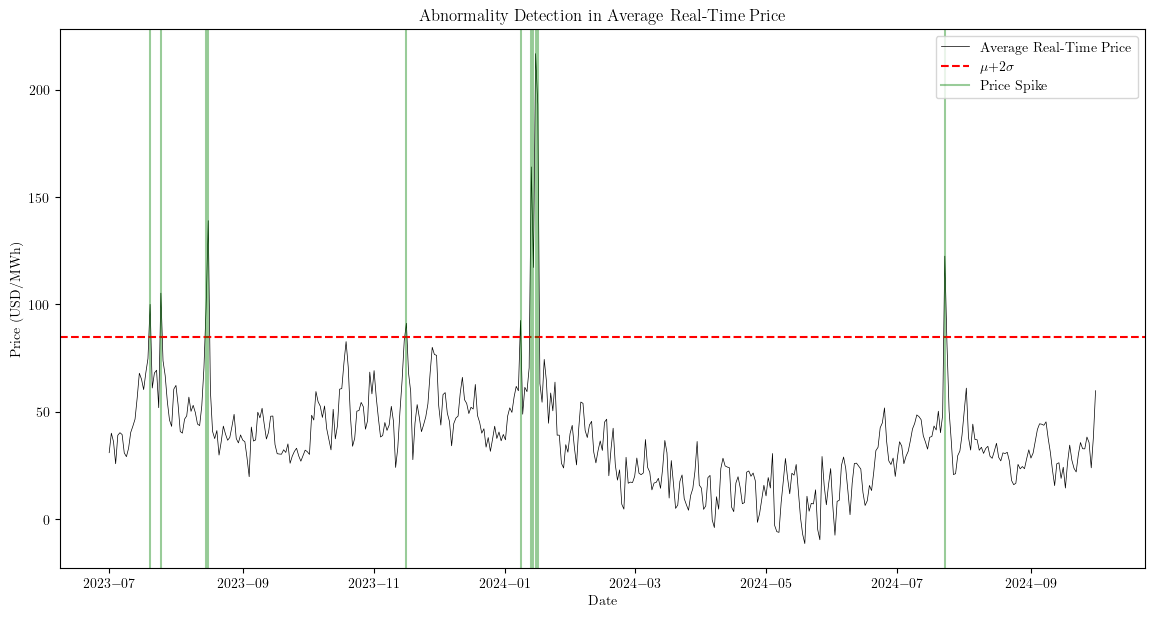

DatetimeIndex(['2023-07-20', '2023-07-25', '2023-08-15', '2023-08-16',
               '2023-11-16', '2024-01-08', '2024-01-13', '2024-01-14',
               '2024-01-15', '2024-01-16', '2024-07-23'],
              dtype='datetime64[ns]', freq=None)


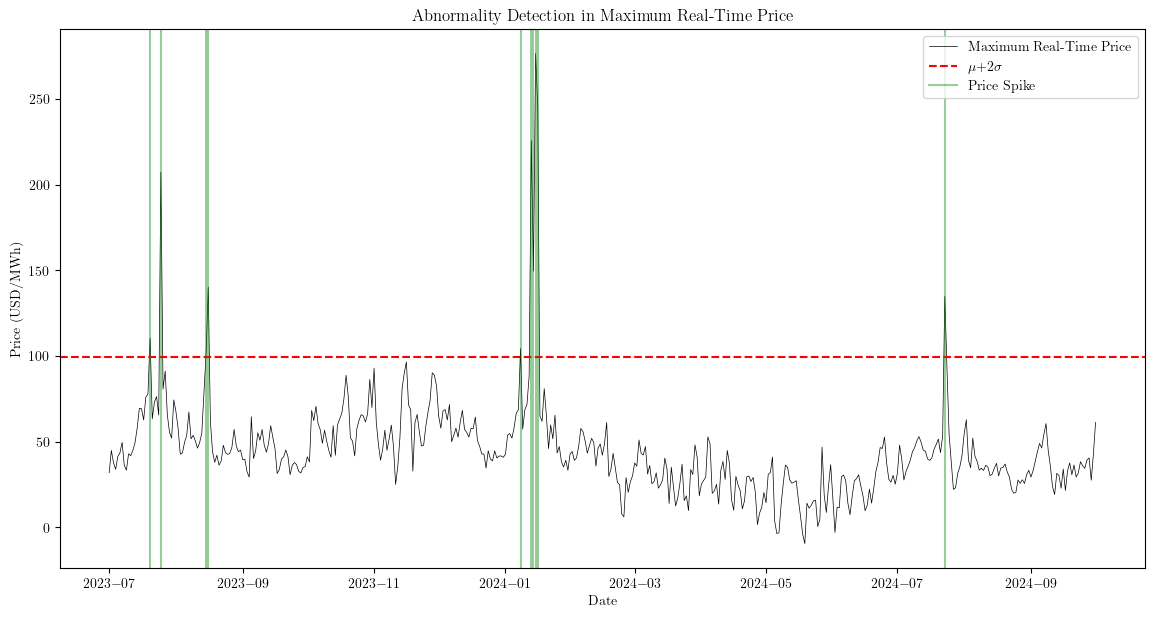

DatetimeIndex(['2023-07-20', '2023-07-25', '2023-08-15', '2023-08-16',
               '2024-01-08', '2024-01-13', '2024-01-14', '2024-01-15',
               '2024-01-16', '2024-07-23'],
              dtype='datetime64[ns]', freq=None)


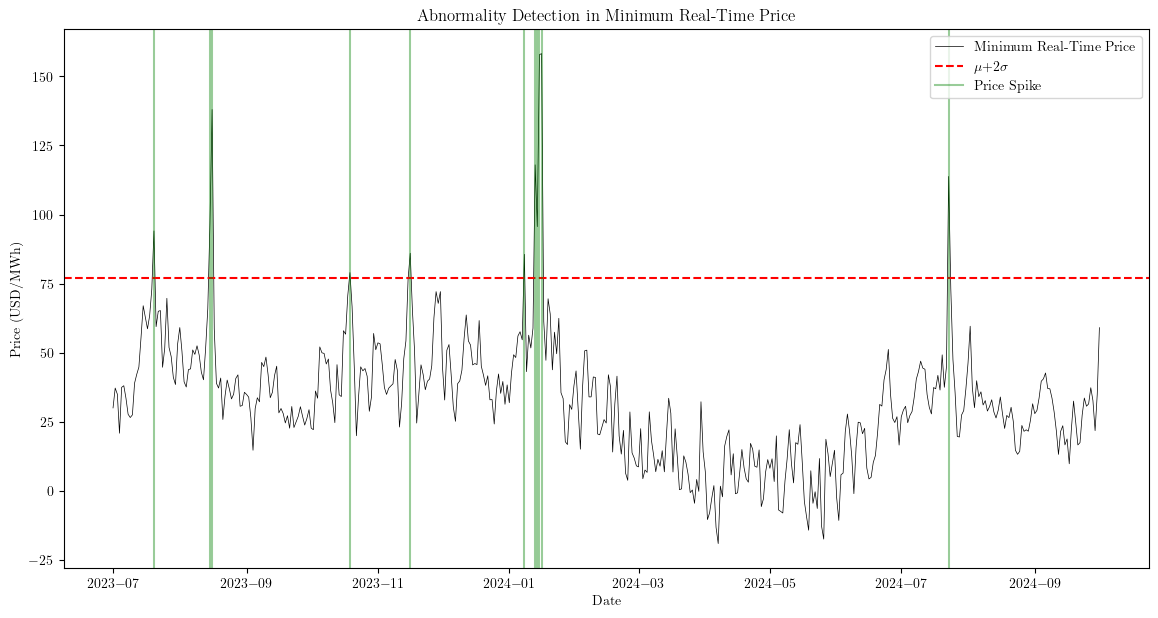

DatetimeIndex(['2023-07-20', '2023-08-15', '2023-08-16', '2023-10-19',
               '2023-11-16', '2024-01-08', '2024-01-13', '2024-01-14',
               '2024-01-15', '2024-01-16', '2024-07-23'],
              dtype='datetime64[ns]', freq=None)


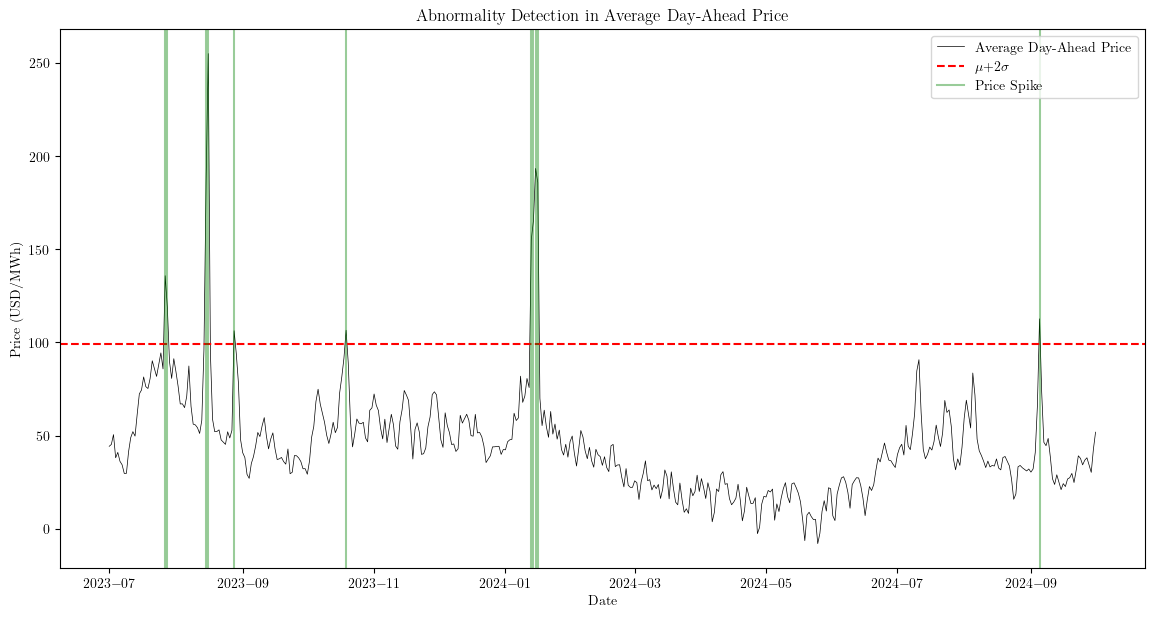

DatetimeIndex(['2023-07-27', '2023-07-28', '2023-08-15', '2023-08-16',
               '2023-08-28', '2023-10-19', '2024-01-13', '2024-01-14',
               '2024-01-15', '2024-01-16', '2024-09-05'],
              dtype='datetime64[ns]', freq=None)


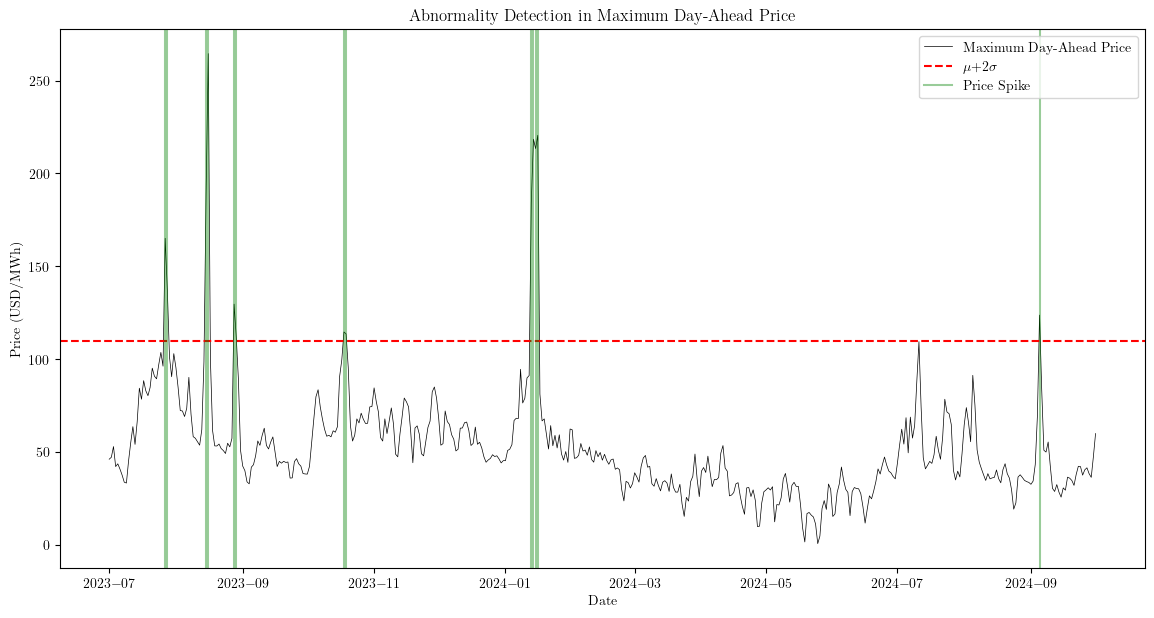

DatetimeIndex(['2023-07-27', '2023-07-28', '2023-08-15', '2023-08-16',
               '2023-08-28', '2023-08-29', '2023-10-18', '2023-10-19',
               '2024-01-13', '2024-01-14', '2024-01-15', '2024-01-16',
               '2024-09-05'],
              dtype='datetime64[ns]', freq=None)


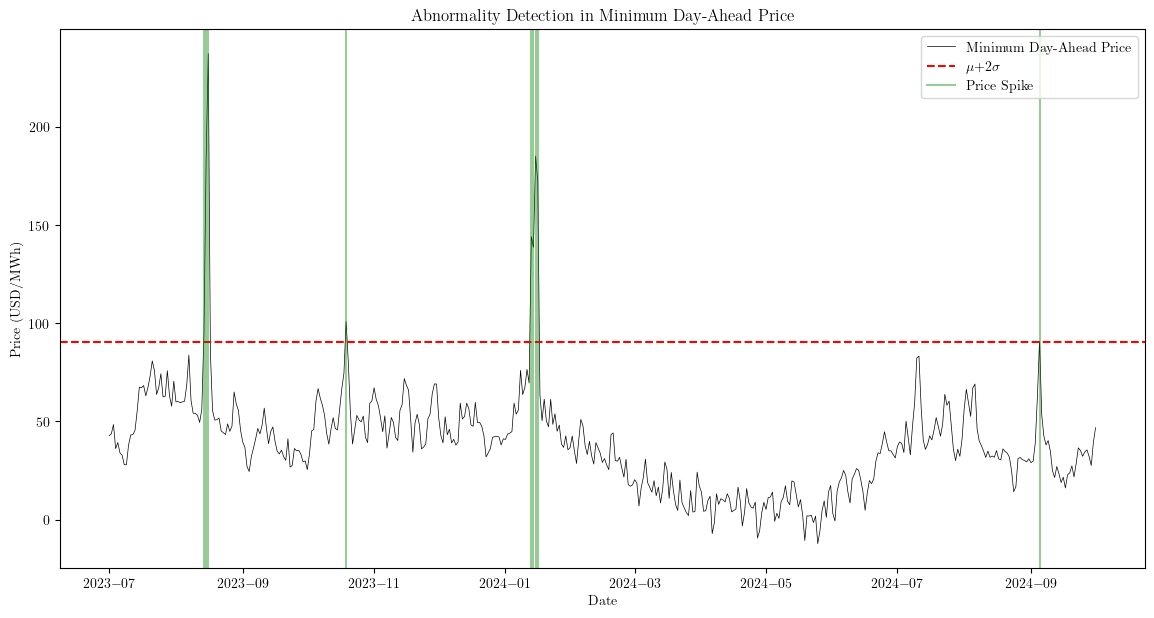

DatetimeIndex(['2023-08-14', '2023-08-15', '2023-08-16', '2023-10-19',
               '2024-01-13', '2024-01-14', '2024-01-15', '2024-01-16',
               '2024-09-05'],
              dtype='datetime64[ns]', freq=None)


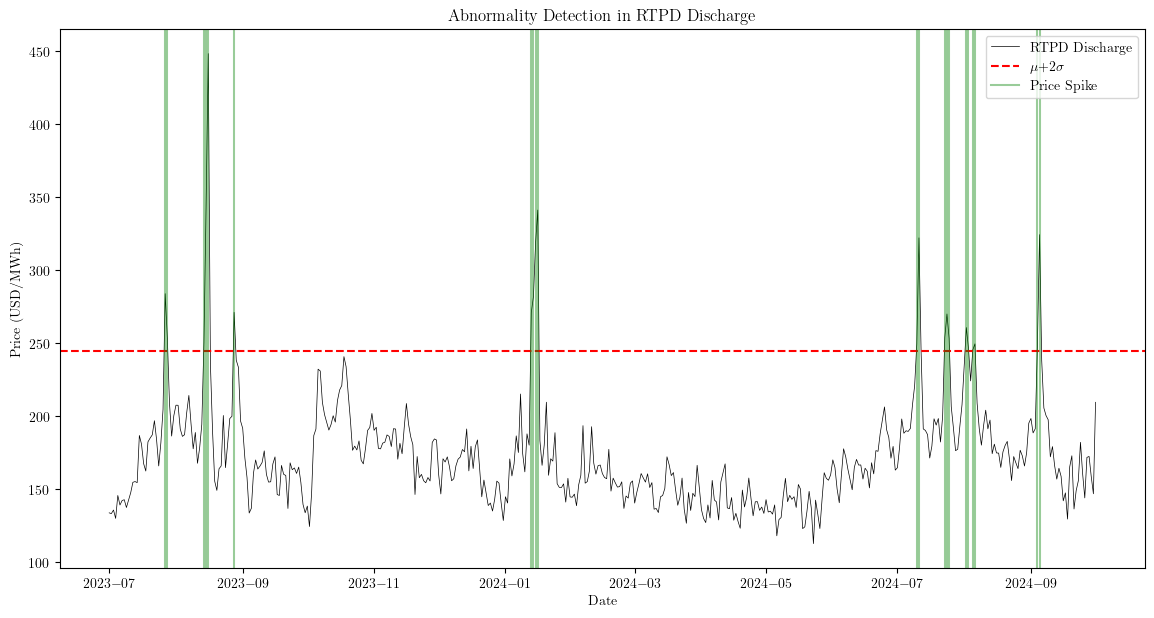

DatetimeIndex(['2023-07-27', '2023-07-28', '2023-08-14', '2023-08-15',
               '2023-08-16', '2023-08-28', '2024-01-13', '2024-01-14',
               '2024-01-15', '2024-01-16', '2024-07-10', '2024-07-11',
               '2024-07-23', '2024-07-24', '2024-07-25', '2024-08-02',
               '2024-08-03', '2024-08-05', '2024-08-06', '2024-09-04',
               '2024-09-05'],
              dtype='datetime64[ns]', freq=None)


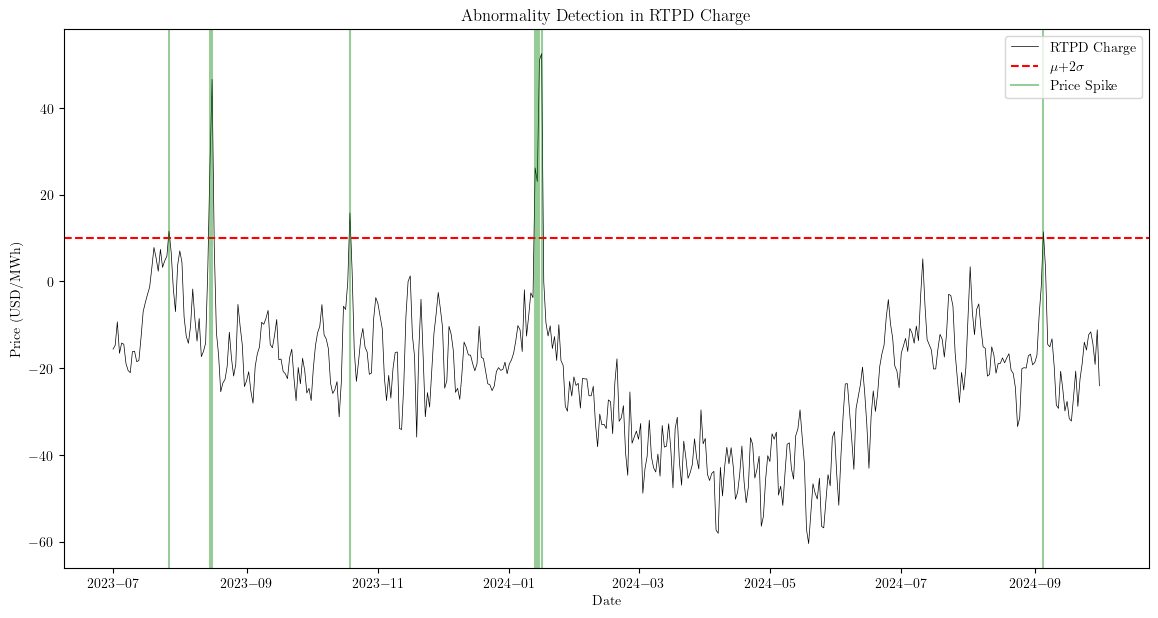

DatetimeIndex(['2023-07-27', '2023-08-15', '2023-08-16', '2023-10-19',
               '2024-01-13', '2024-01-14', '2024-01-15', '2024-01-16',
               '2024-09-05'],
              dtype='datetime64[ns]', freq=None)


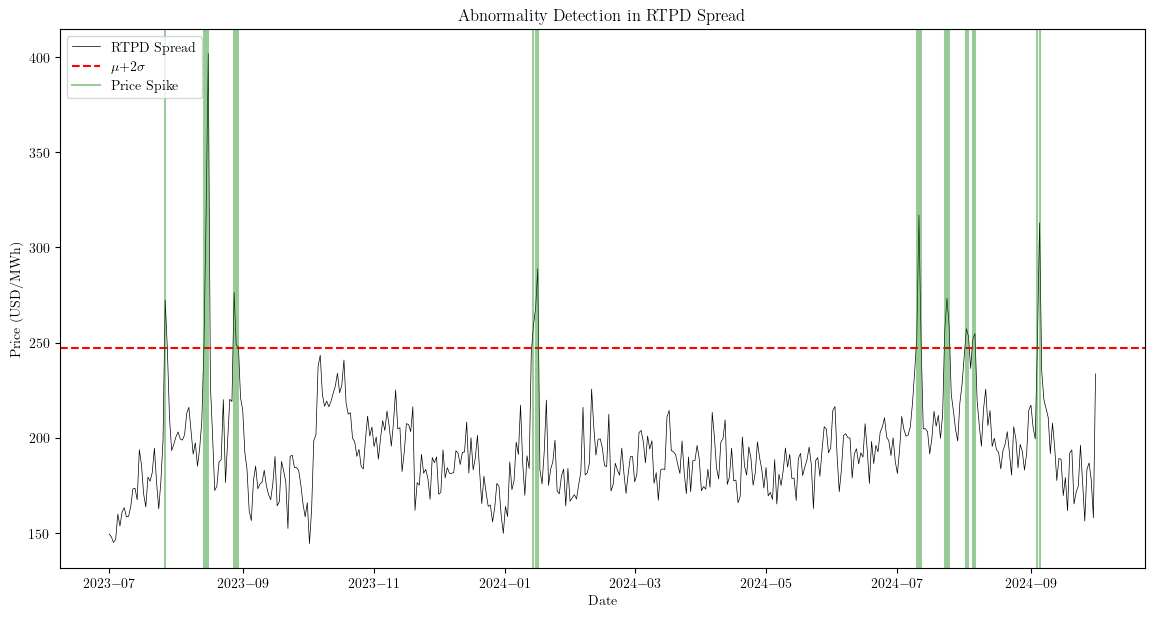

DatetimeIndex(['2023-07-27', '2023-08-14', '2023-08-15', '2023-08-16',
               '2023-08-28', '2023-08-29', '2023-08-30', '2024-01-14',
               '2024-01-15', '2024-01-16', '2024-07-10', '2024-07-11',
               '2024-07-12', '2024-07-23', '2024-07-24', '2024-07-25',
               '2024-08-02', '2024-08-03', '2024-08-05', '2024-08-06',
               '2024-09-04', '2024-09-05'],
              dtype='datetime64[ns]', freq=None)


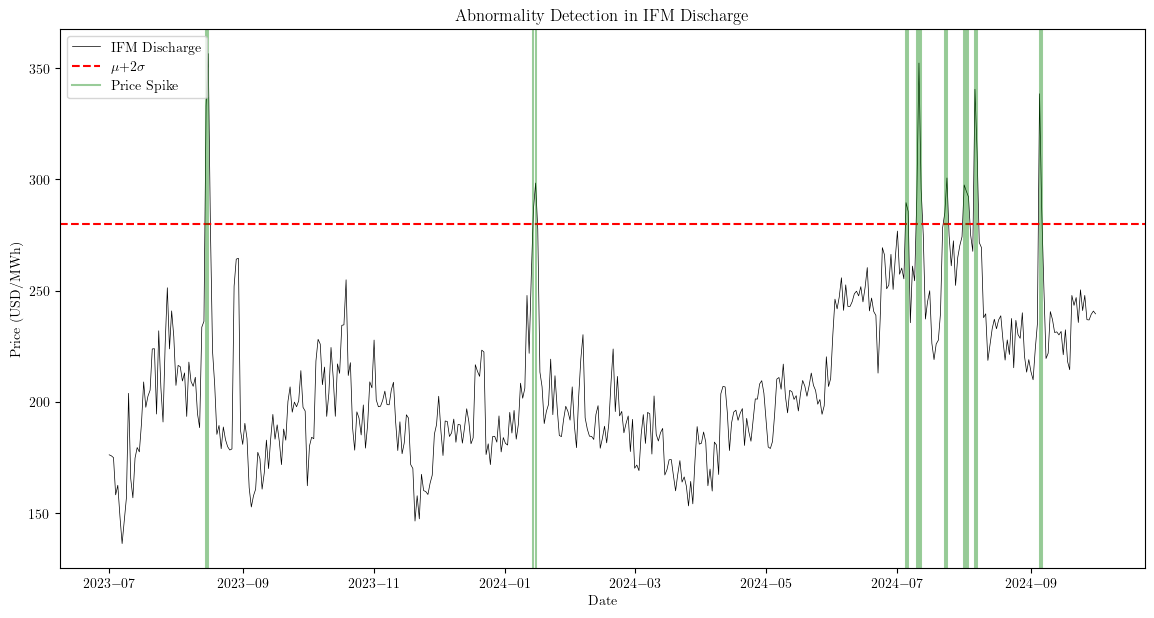

DatetimeIndex(['2023-08-15', '2023-08-16', '2024-01-14', '2024-01-15',
               '2024-07-05', '2024-07-06', '2024-07-10', '2024-07-11',
               '2024-07-12', '2024-07-23', '2024-07-24', '2024-08-01',
               '2024-08-02', '2024-08-03', '2024-08-06', '2024-08-07',
               '2024-09-05', '2024-09-06'],
              dtype='datetime64[ns]', freq=None)


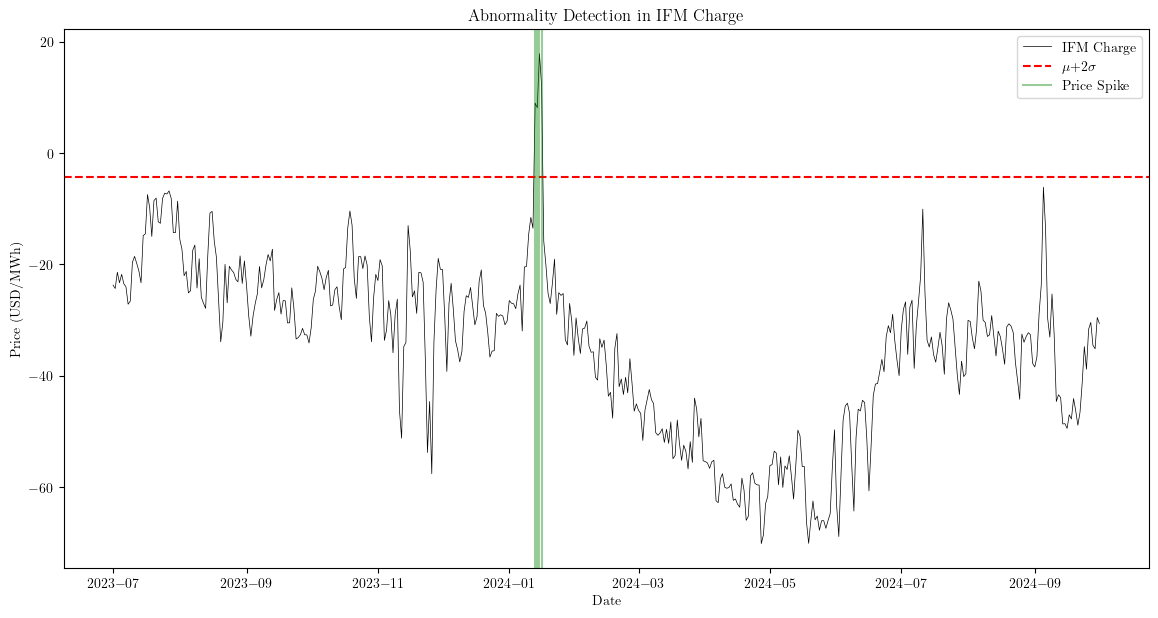

DatetimeIndex(['2024-01-13', '2024-01-14', '2024-01-15', '2024-01-16'], dtype='datetime64[ns]', freq='D')


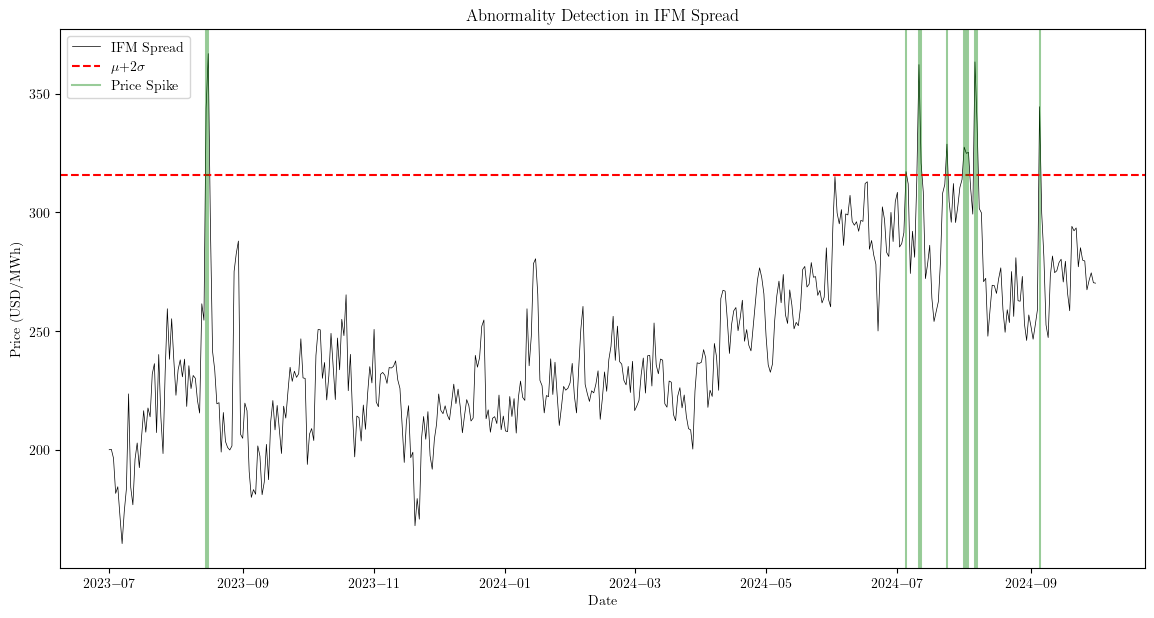

DatetimeIndex(['2023-08-15', '2023-08-16', '2024-07-05', '2024-07-11',
               '2024-07-12', '2024-07-24', '2024-08-01', '2024-08-02',
               '2024-08-03', '2024-08-06', '2024-08-07', '2024-09-05'],
              dtype='datetime64[ns]', freq=None)


In [131]:
RTP_spike_days_avg = identify_spikes(
    data=daily_df, column="rt_price_avg", description="Average Real-Time Price"
)
print(RTP_spike_days_avg)

RTP_spike_days_max = identify_spikes(
    data=daily_df, column="rt_price_max", description="Maximum Real-Time Price"
)
print(RTP_spike_days_max)

RTP_spike_days_min = identify_spikes(
    data=daily_df, column="rt_price_min", description="Minimum Real-Time Price"
)
print(RTP_spike_days_min)

DAP_spike_days_avg = identify_spikes(
    data=daily_df, column="da_price_avg", description="Average Day-Ahead Price"
)
print(DAP_spike_days_avg)

DAP_spike_days_max = identify_spikes(
    data=daily_df, column="da_price_max", description="Maximum Day-Ahead Price"
)
print(DAP_spike_days_max)

DAP_spike_days_min = identify_spikes(
    data=daily_df, column="da_price_min", description="Minimum Day-Ahead Price"
)
print(DAP_spike_days_min)

RTPD_discharge_days = identify_spikes(
    data=daily_df, column="bid_rtpd_pos_weighted", description="RTPD Discharge"
)
print(RTPD_discharge_days)

RTPD_charge_days = identify_spikes(
    data=daily_df, column="bid_rtpd_neg_weighted", description="RTPD Charge"
)
print(RTPD_charge_days)

RTPD_spread_days = identify_spikes(
    data=daily_df, column="bid_rtpd_weighted_spread", description="RTPD Spread"
)
print(RTPD_spread_days)

IFM_discharge_days = identify_spikes(
    data=daily_df, column="bid_ifm_pos_weighted", description="IFM Discharge"
)
print(IFM_discharge_days)

IFM_charge_days = identify_spikes(
    data=daily_df, column="bid_ifm_neg_weighted", description="IFM Charge"
)
print(IFM_charge_days)

IFM_spread_days = identify_spikes(
    data=daily_df, column="bid_ifm_weighted_spread", description="IFM Spread"
)
print(IFM_spread_days)

## Hourly Weighted Bids on Price Spike vs. Non-Price Spike Days

In [151]:
def plot_price_spike_distributions(
    data: pd.DataFrame = None,
    spike_days: list = None,
    market: str = None,
    spike_days_description: str = None,
):
    # Separate the data into price spike days and non-price spike days
    price_spike_hourly_index = data.index.floor("D").isin(spike_days)

    # Plot the histograms
    plt.figure(figsize=(12, 6))

    # Histogram for non-price spike days
    plt.hist(
        data[~price_spike_hourly_index][f"bid_{market.lower()}_weighted_spread"],
        bins=30,
        alpha=0.5,
        label="Non Price Spike Days",
        density=True,
    )

    # Histogram for price spike days
    plt.hist(
        data[price_spike_hourly_index][f"bid_{market.lower()}_weighted_spread"],
        bins=30,
        alpha=0.5,
        label="Price Spike Days",
        density=True,
    )

    # Add title and labels
    plt.title(
        f"{spike_days_description} Price Spike Days vs Non Price Spike Days Weighted {market.upper()} Average Bid Spread Distribution"
    )
    plt.xlabel(f"Weighted {market.upper()} Average Bid Spread")
    plt.ylabel("Relative Frequency")
    plt.legend()

    # Show the plot
    plt.show()

    # Extract the data for KS test
    price_spike_data = (
        data[price_spike_hourly_index][f"bid_{market.lower()}_weighted_spread"]
        .dropna()
        .values
    )
    non_price_spike_data = (
        data[~price_spike_hourly_index][f"bid_{market.lower()}_weighted_spread"]
        .dropna()
        .values
    )

    # Perform the KS test
    ks_statistic, p_value = ks_2samp(price_spike_data, non_price_spike_data)

    # Print the results
    print(f"KS Statistic: {ks_statistic}")
    print(f"P-value: {p_value}")
    print("n price spike:", len(price_spike_data))
    print("n non price spike:", len(non_price_spike_data))

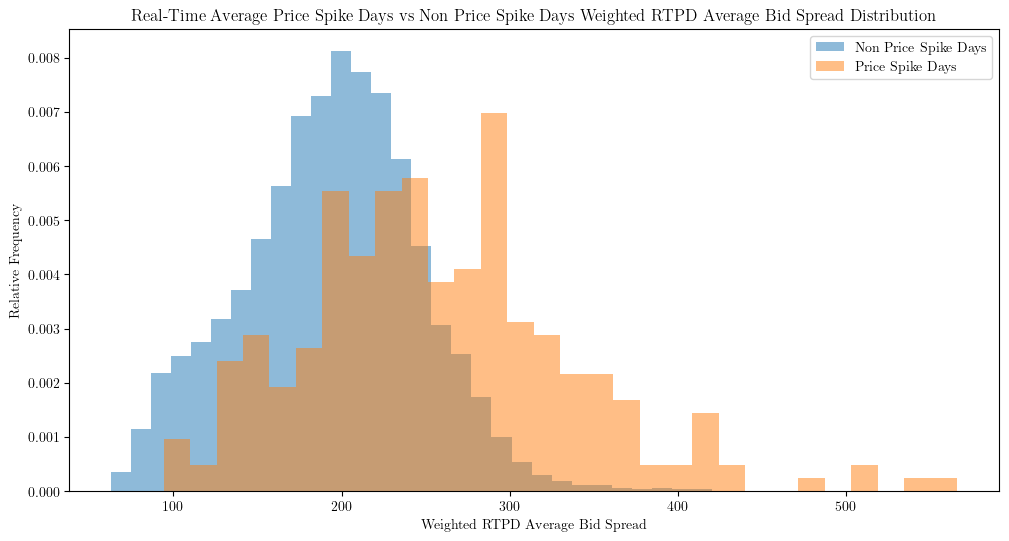

KS Statistic: 0.3856293706293706
P-value: 4.912124507459774e-35
n price spike: 264
n non price spike: 10725


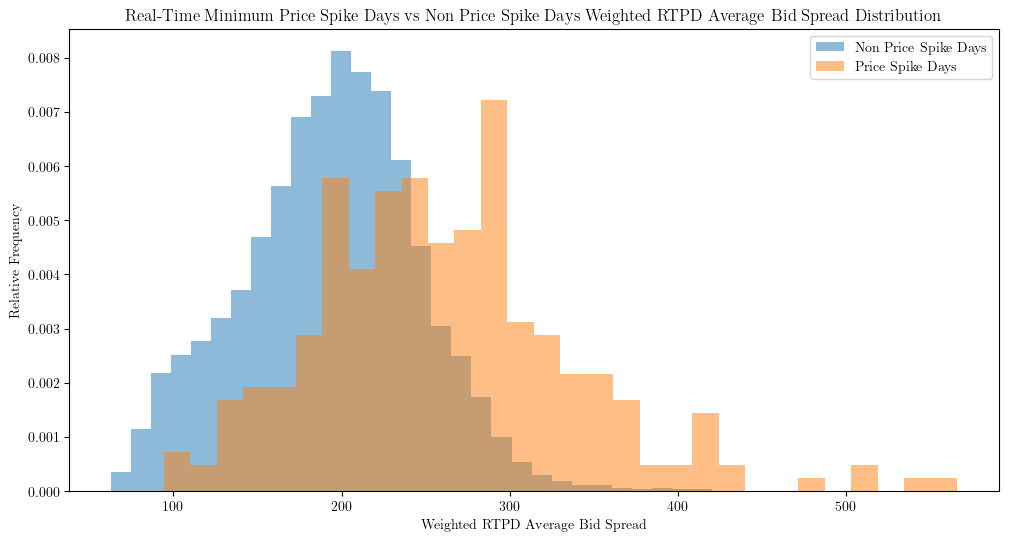

KS Statistic: 0.41279720279720283
P-value: 2.6894217974766363e-40
n price spike: 264
n non price spike: 10725


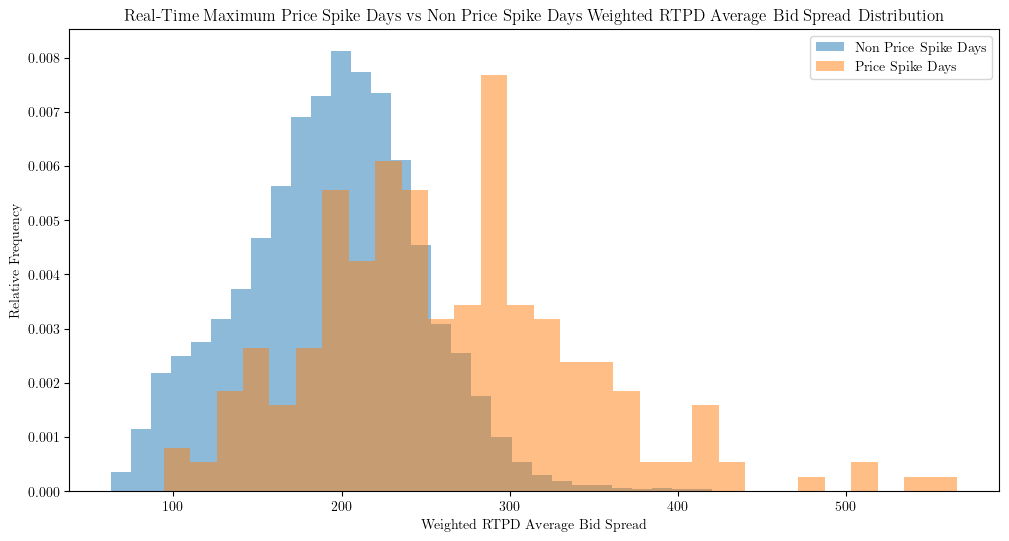

KS Statistic: 0.39803702670015817
P-value: 4.241108530993637e-34
n price spike: 240
n non price spike: 10749


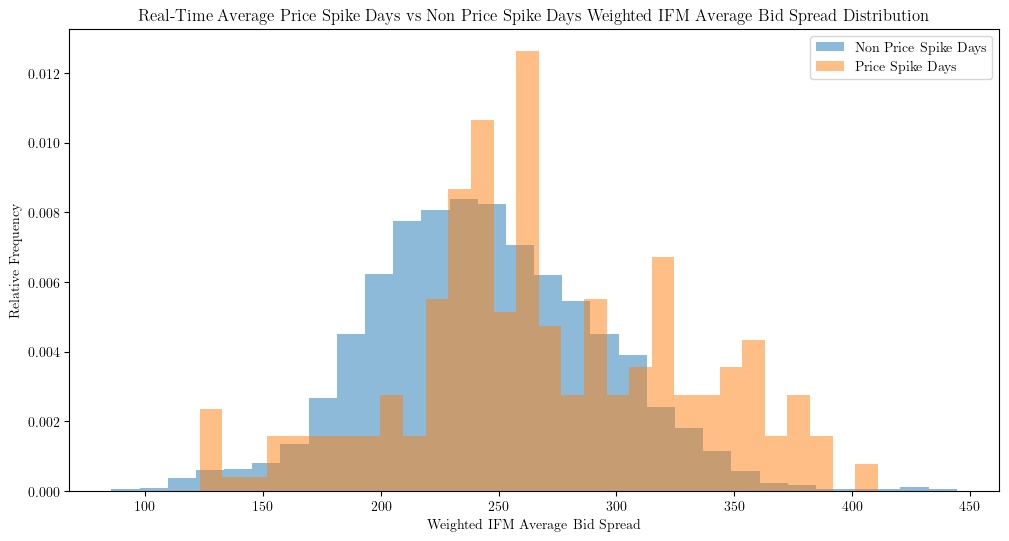

KS Statistic: 0.20762999118703815
P-value: 3.11233652528492e-10
n price spike: 264
n non price spike: 10728


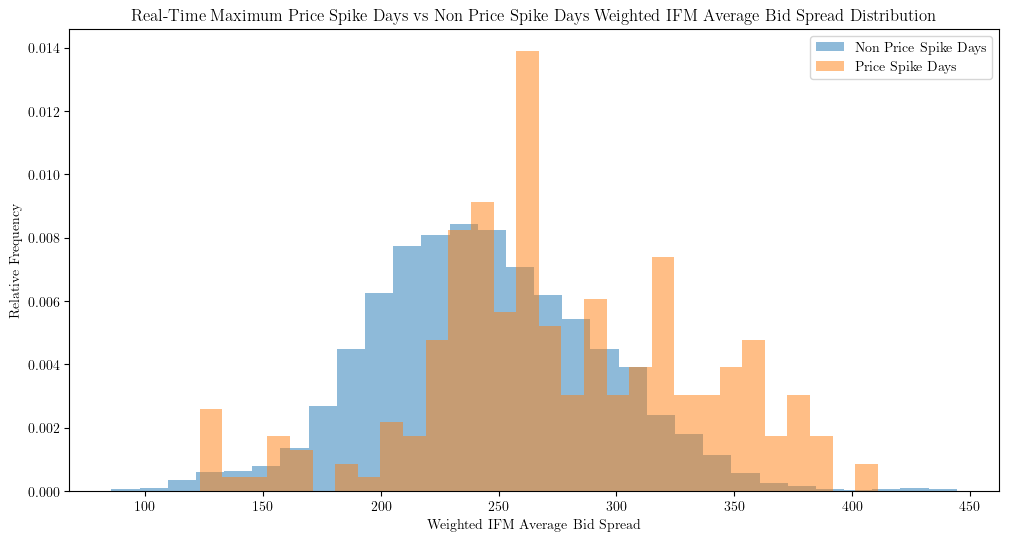

KS Statistic: 0.25755208333333335
P-value: 3.1006646112879656e-14
n price spike: 240
n non price spike: 10752


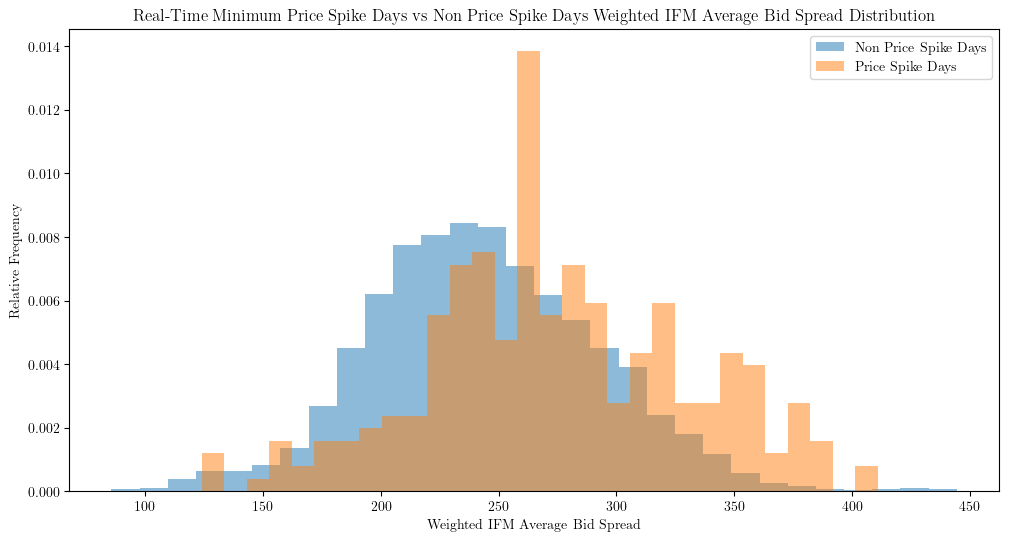

KS Statistic: 0.26627855738594
P-value: 1.2213130055074525e-16
n price spike: 264
n non price spike: 10728


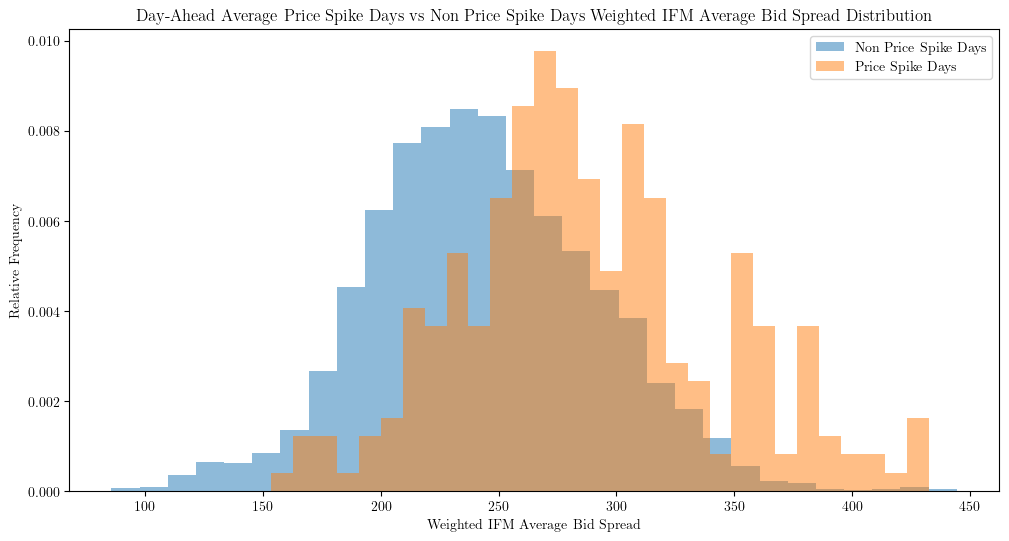

KS Statistic: 0.3602298149278015
P-value: 1.726399000266834e-30
n price spike: 264
n non price spike: 10728


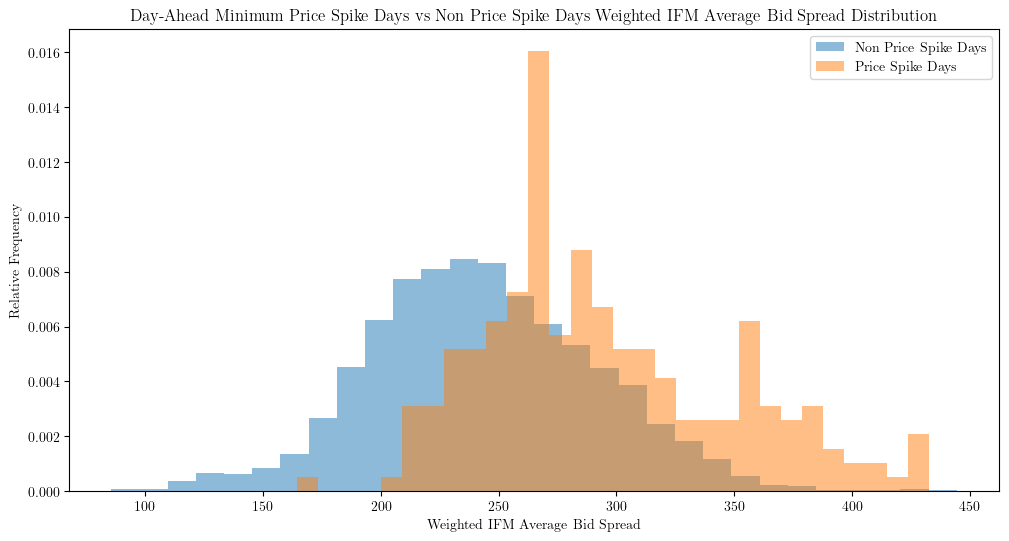

KS Statistic: 0.40762393796914953
P-value: 2.3586325237227303e-32
n price spike: 216
n non price spike: 10776


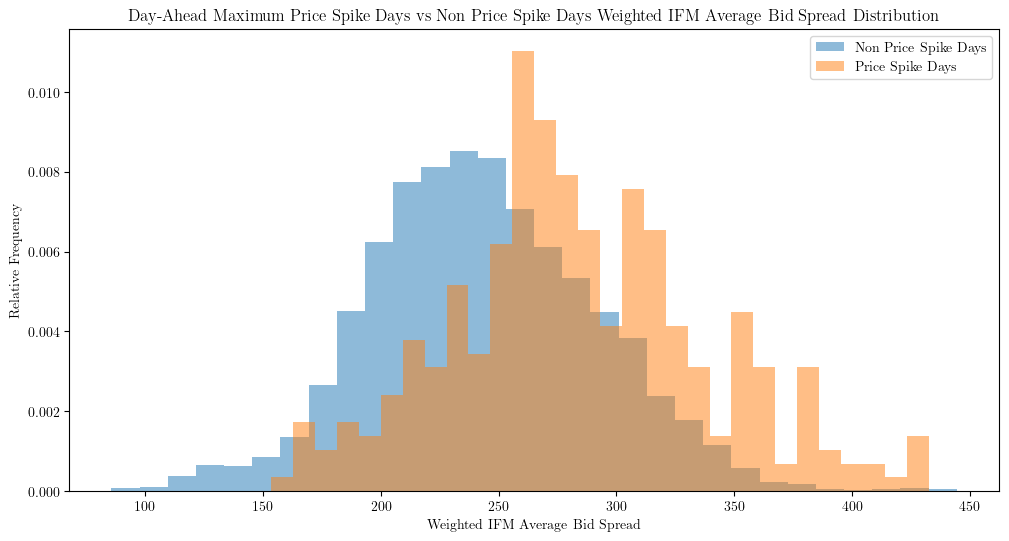

KS Statistic: 0.345880149812734
P-value: 6.937620295775304e-33
n price spike: 312
n non price spike: 10680


In [152]:
plot_price_spike_distributions(
    data=hourly_df,
    spike_days=RTP_spike_days_avg,
    market="rtpd",
    spike_days_description="Real-Time Average",
)

plot_price_spike_distributions(
    data=hourly_df,
    spike_days=RTP_spike_days_min,
    market="rtpd",
    spike_days_description="Real-Time Minimum",
)

plot_price_spike_distributions(
    data=hourly_df,
    spike_days=RTP_spike_days_max,
    market="rtpd",
    spike_days_description="Real-Time Maximum",
)

plot_price_spike_distributions(
    data=hourly_df,
    spike_days=RTP_spike_days_avg,
    market="ifm",
    spike_days_description="Real-Time Average",
)

plot_price_spike_distributions(
    data=hourly_df,
    spike_days=RTP_spike_days_max,
    market="ifm",
    spike_days_description="Real-Time Maximum",
)

plot_price_spike_distributions(
    data=hourly_df,
    spike_days=RTP_spike_days_min,
    market="ifm",
    spike_days_description="Real-Time Minimum",
)

plot_price_spike_distributions(
    data=hourly_df,
    spike_days=DAP_spike_days_avg,
    market="ifm",
    spike_days_description="Day-Ahead Average",
)

plot_price_spike_distributions(
    data=hourly_df,
    spike_days=DAP_spike_days_min,
    market="ifm",
    spike_days_description="Day-Ahead Minimum",
)

plot_price_spike_distributions(
    data=hourly_df,
    spike_days=DAP_spike_days_max,
    market="ifm",
    spike_days_description="Day-Ahead Maximum",
)

## Price vs. Bid Spread

In [134]:
def plot_price_bid_spread(
    data: pd.DataFrame = None,
    spike_days: list = None,
    market: str = None,
    price_col: str = None,
    spike_days_description: str = None,
):

    # Separate the data into price spike days and non-price spike days
    price_spike_hourly_index = data.index.floor("D").isin(spike_days)

    # Plot the histograms
    plt.figure(figsize=(10, 6))

    # Histogram for non-price spike days
    plt.scatter(
        data[~price_spike_hourly_index][price_col],
        data[~price_spike_hourly_index][f"bid_{market.lower()}_weighted_spread"],
        alpha=0.5,
        label="Non Price Spike Days",
        s=4,
    )

    # Histogram for price spike days
    plt.scatter(
        data[price_spike_hourly_index][price_col],
        data[price_spike_hourly_index][f"bid_{market.lower()}_weighted_spread"],
        alpha=0.5,
        label="Price Spike Days",
        s=4,
    )

    # Add title and labels
    plt.title(f"{spike_days_description} Price vs. Average {market.upper()} Bid Spread")
    plt.xlabel(f"{spike_days_description} Price (\$/MWh)")
    plt.ylabel(f"Weighted Average {market.upper()} Bid Spread (\$/MWh)")
    plt.legend()

    # Show the plot
    plt.show()

<>:35: SyntaxWarning: invalid escape sequence '\$'
<>:36: SyntaxWarning: invalid escape sequence '\$'
<>:35: SyntaxWarning: invalid escape sequence '\$'
<>:36: SyntaxWarning: invalid escape sequence '\$'
C:\Users\Astro\AppData\Local\Temp\ipykernel_17112\3533380981.py:35: SyntaxWarning: invalid escape sequence '\$'
  plt.xlabel(f"{spike_days_description} Price (\$/MWh)")
C:\Users\Astro\AppData\Local\Temp\ipykernel_17112\3533380981.py:36: SyntaxWarning: invalid escape sequence '\$'
  plt.ylabel(f"Weighted Average {market.upper()} Bid Spread (\$/MWh)")


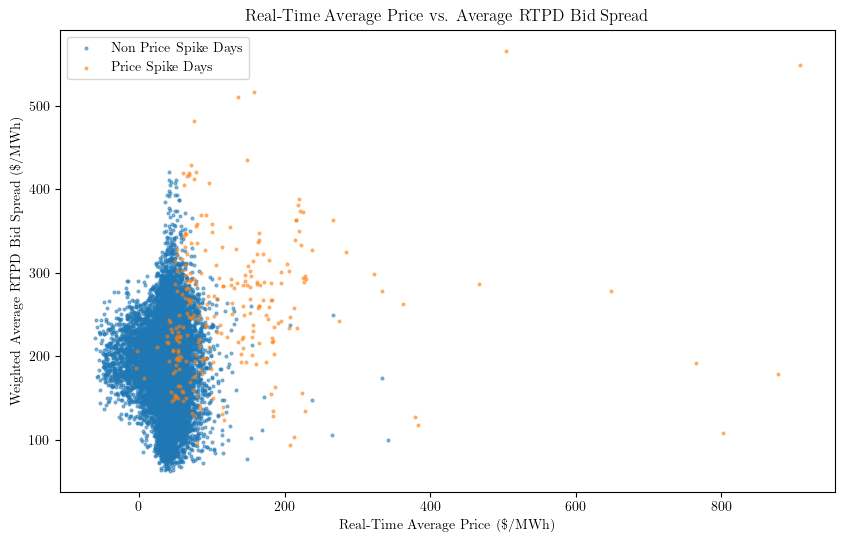

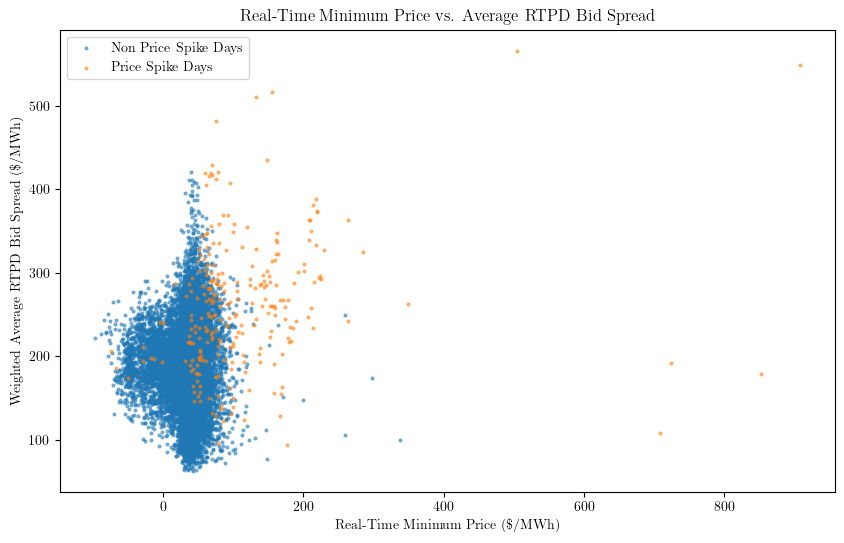

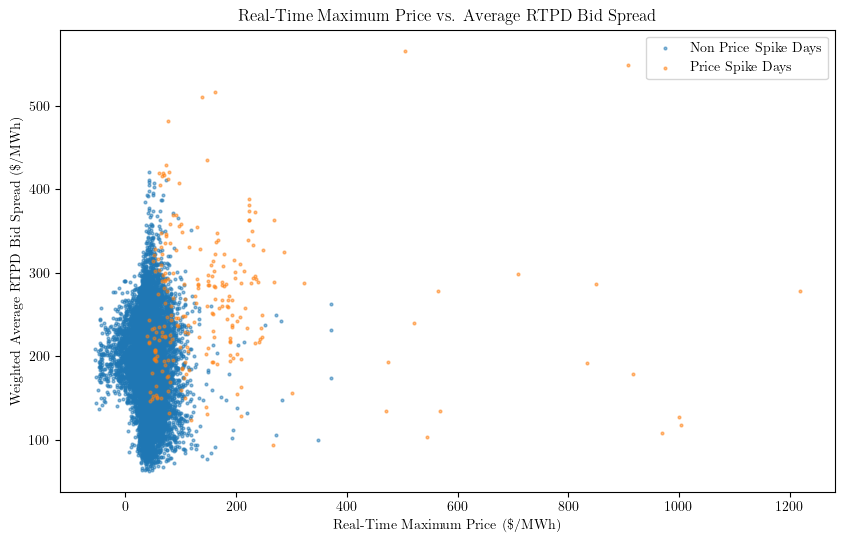

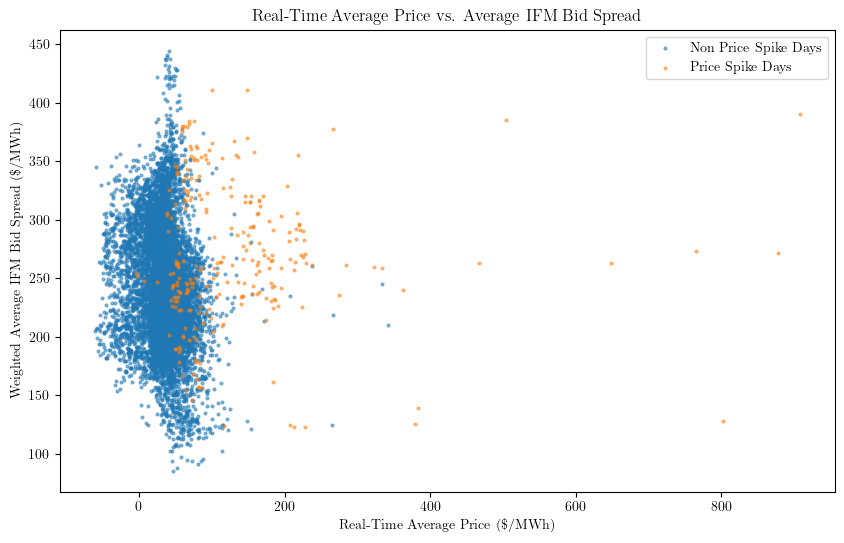

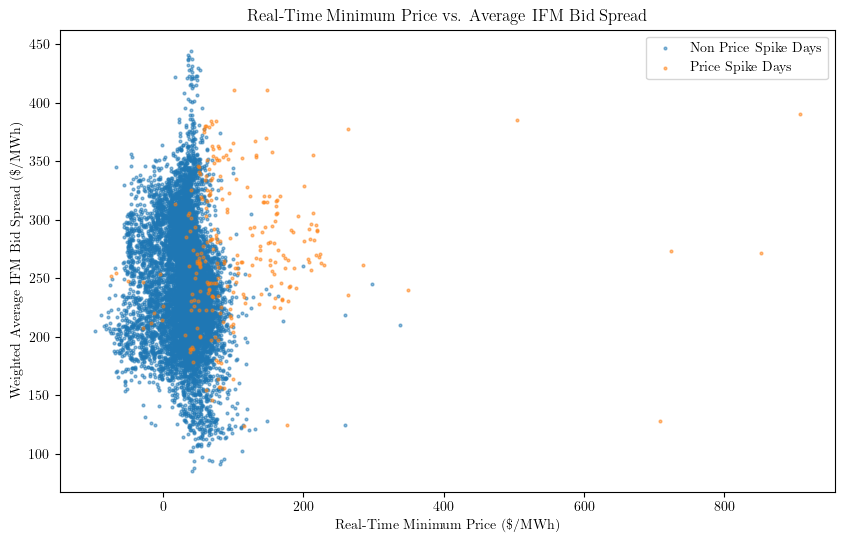

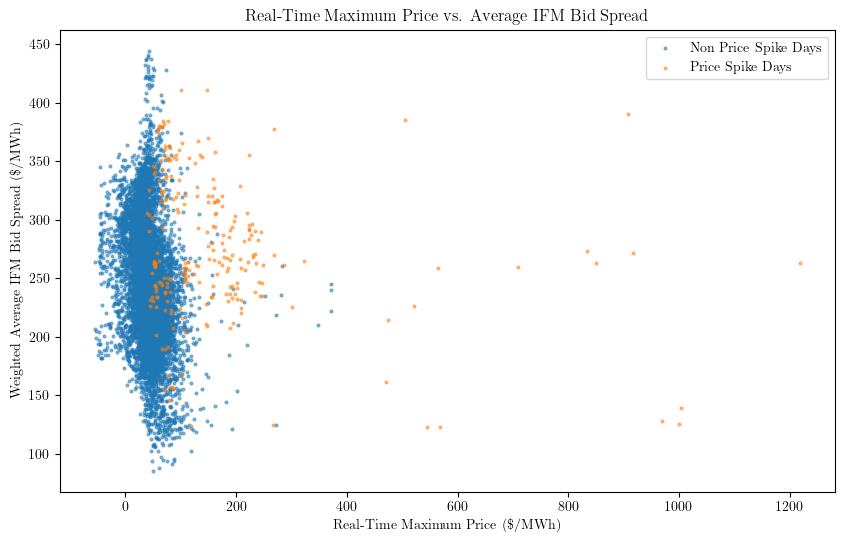

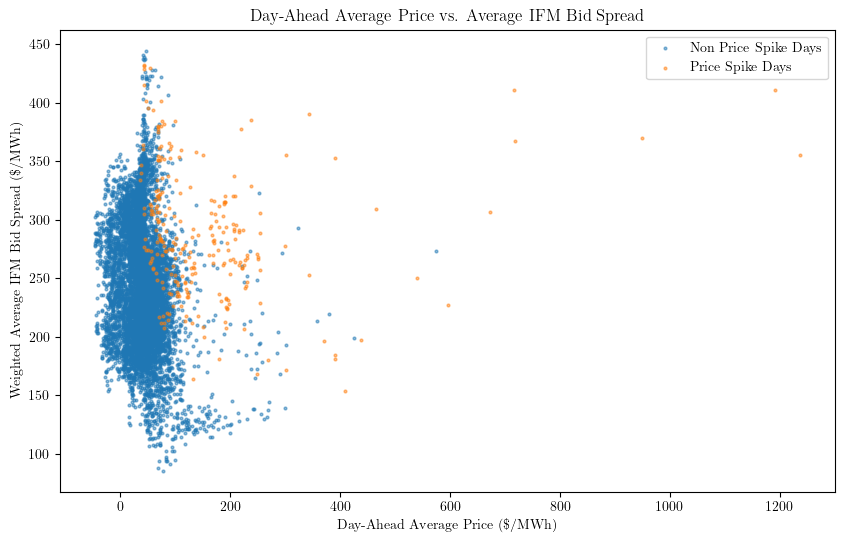

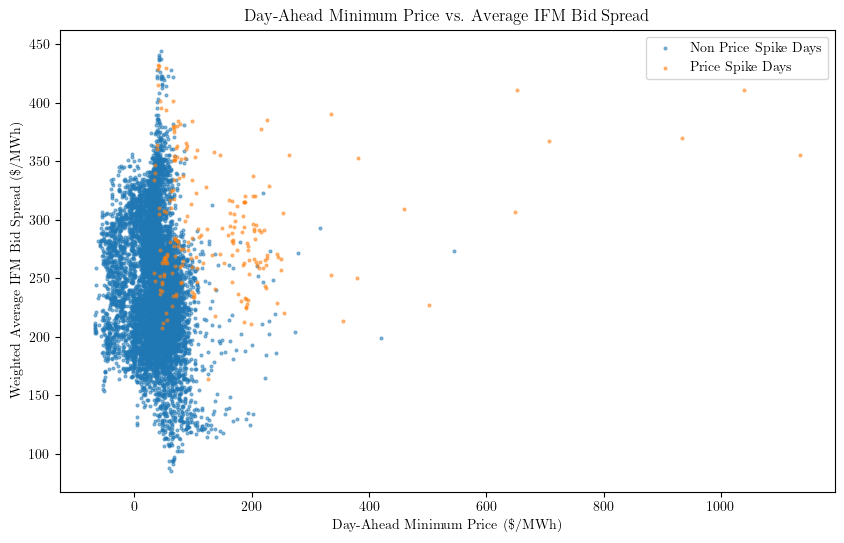

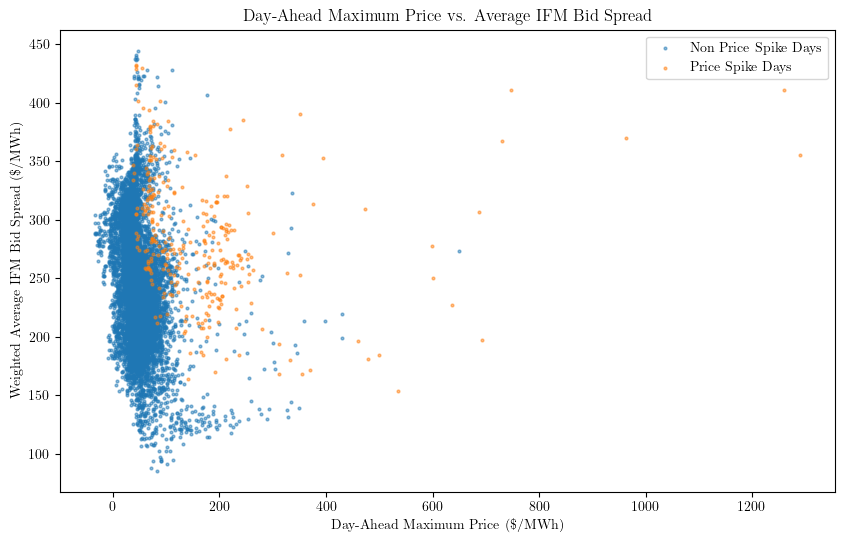

In [135]:
plot_price_bid_spread(
    data=hourly_df,
    spike_days=RTP_spike_days_avg,
    market="rtpd",
    price_col="rt_price_avg",
    spike_days_description="Real-Time Average",
)

plot_price_bid_spread(
    data=hourly_df,
    spike_days=RTP_spike_days_min,
    market="rtpd",
    price_col="rt_price_min",
    spike_days_description="Real-Time Minimum",
)

plot_price_bid_spread(
    data=hourly_df,
    spike_days=RTP_spike_days_max,
    market="rtpd",
    price_col="rt_price_max",
    spike_days_description="Real-Time Maximum",
)

plot_price_bid_spread(
    data=hourly_df,
    spike_days=RTP_spike_days_avg,
    market="ifm",
    price_col="rt_price_avg",
    spike_days_description="Real-Time Average",
)

plot_price_bid_spread(
    data=hourly_df,
    spike_days=RTP_spike_days_min,
    market="ifm",
    price_col="rt_price_min",
    spike_days_description="Real-Time Minimum",
)

plot_price_bid_spread(
    data=hourly_df,
    spike_days=RTP_spike_days_max,
    market="ifm",
    price_col="rt_price_max",
    spike_days_description="Real-Time Maximum",
)

plot_price_bid_spread(
    data=hourly_df,
    spike_days=DAP_spike_days_avg,
    market="ifm",
    price_col="da_price_avg",
    spike_days_description="Day-Ahead Average",
)

plot_price_bid_spread(
    data=hourly_df,
    spike_days=DAP_spike_days_min,
    market="ifm",
    price_col="da_price_min",
    spike_days_description="Day-Ahead Minimum",
)

plot_price_bid_spread(
    data=hourly_df,
    spike_days=DAP_spike_days_max,
    market="ifm",
    price_col="da_price_max",
    spike_days_description="Day-Ahead Maximum",
)

## Bid Distributions

In [136]:
def plot_bid_distribution(
    data: pd.DataFrame = None,
    start_date: pd.Timestamp = None,
    end_date: pd.Timestamp = None,
    date_descriptor: str = None,
    savefile: str = "",
):
    filtered_data = data.copy()
    if start_date != None:
        filtered_data = filtered_data[filtered_data.index >= start_date]
    if end_date != None:
        filtered_data = filtered_data[filtered_data.index <= end_date]

    rtpd_pos_cols = [f"bid_rtpd_pos_{seg}_prop" for seg in range(1, 11)]
    rtpd_neg_cols = [f"bid_rtpd_neg_{seg}_prop" for seg in range(1, 11)]
    ifm_pos_cols = [f"bid_ifm_pos_{seg}_prop" for seg in range(1, 11)]
    ifm_neg_cols = [f"bid_ifm_neg_{seg}_prop" for seg in range(1, 11)]

    fig, axs = plt.subplots(
        2, 2, figsize=(12, 6), sharex=True, sharey=False, gridspec_kw={"hspace": 0.15}
    )

    max_val = max(
        0.5,
        (
            (
                filtered_data[
                    rtpd_pos_cols + rtpd_neg_cols + ifm_pos_cols + ifm_neg_cols
                ]
                .mean()
                .max()
                // 0.05
            )
            + 1
        )
        * 0.05,
    )

    # Calculate the bins for average and maximum prices
    rtpd_avg_price_bin = np.digitize(
        filtered_data["rt_price_avg"].mean(), bid_segment_edges
    )
    rtpd_max_price_bin = np.digitize(
        filtered_data["rt_price_max"].max(), bid_segment_edges
    )
    ifm_avg_price_bin = np.digitize(
        filtered_data["da_price_avg"].mean(), bid_segment_edges
    )
    ifm_max_price_bin = np.digitize(
        filtered_data["da_price_max"].max(), bid_segment_edges
    )

    axs[0, 0].bar(
        range(len(rtpd_pos_cols)),
        filtered_data[rtpd_pos_cols].mean(),
        color="black",
        alpha=1.0,
        width=1.0,
    )
    axs[0, 0].axvline(
        rtpd_avg_price_bin - 1, color="blue", linestyle="-.", label="Avg Price Bin"
    )
    axs[0, 0].axvline(
        rtpd_max_price_bin - 1, color="red", linestyle="--", label="Max Price Bin"
    )
    axs[0, 0].set_title("RTPD Discharge Bid Proportions")
    axs[0, 0].set_xticks(range(len(rtpd_pos_cols)))
    axs[0, 0].set_xticklabels(
        [f"{bid_segments[str(i)]}" for i in range(1, 11)], rotation=45
    )
    axs[0, 0].set_ylabel("Proportion")

    axs[0, 1].bar(
        range(len(ifm_pos_cols)),
        filtered_data[ifm_pos_cols].mean(),
        color="black",
        alpha=1.0,
        width=1.0,
    )
    axs[0, 1].axvline(
        ifm_avg_price_bin - 1, color="blue", linestyle="-.", label="Avg Price Bin"
    )
    axs[0, 1].axvline(
        ifm_max_price_bin - 1, color="red", linestyle="--", label="Max Price Bin"
    )
    axs[0, 1].set_title("IFM Discharge Bid Proportions")
    axs[0, 1].set_xticks(range(len(ifm_pos_cols)))
    axs[0, 1].set_xticklabels(
        [f"{bid_segments[str(i)]}" for i in range(1, 11)], rotation=45
    )
    axs[0, 1].set_ylabel("Proportion")

    axs[1, 0].bar(
        range(len(rtpd_neg_cols)),
        filtered_data[rtpd_neg_cols].mean(),
        color="black",
        alpha=1.0,
        width=1.0,
    )
    axs[1, 0].axvline(
        rtpd_avg_price_bin - 1, color="blue", linestyle="-.", label="Avg Price Bin"
    )
    axs[1, 0].axvline(
        rtpd_max_price_bin - 1, color="red", linestyle="--", label="Max Price Bin"
    )
    axs[1, 0].set_title("RTPD Charge Bid Proportions")
    axs[1, 0].set_xticks(range(len(rtpd_neg_cols)))
    axs[1, 0].set_xticklabels(
        [f"{bid_segments[str(i)]}" for i in range(1, 11)], rotation=45
    )
    axs[1, 0].set_ylabel("Proportion")
    axs[1, 0].invert_yaxis()

    axs[1, 1].bar(
        range(len(ifm_neg_cols)),
        filtered_data[ifm_neg_cols].mean(),
        color="black",
        alpha=1.0,
        width=1.0,
    )
    axs[1, 1].axvline(
        ifm_avg_price_bin - 1, color="blue", linestyle="-.", label="Avg Price Bin"
    )
    axs[1, 1].axvline(
        ifm_max_price_bin - 1, color="red", linestyle="--", label="Max Price Bin"
    )
    axs[1, 1].set_title("IFM Charge Bid Proportions")
    axs[1, 1].set_xticks(range(len(ifm_neg_cols)))
    axs[1, 1].set_xticklabels(
        [f"{bid_segments[str(i)]}" for i in range(1, 11)], rotation=45
    )
    axs[1, 1].set_ylabel("Proportion")
    axs[1, 1].invert_yaxis()

    axs[0, 0].set_ylim(0, max_val)
    axs[0, 1].set_ylim(0, max_val)
    axs[1, 0].set_ylim(max_val, 0)
    axs[1, 1].set_ylim(max_val, 0)

    for ax in axs.flat:
        ax.yaxis.set_major_locator(MultipleLocator(0.1))
        ax.grid(which="both", axis="y", linestyle="--", linewidth=0.5, alpha=0.8)
        ax.grid(which="both", axis="x", linestyle="-", linewidth=0.5, alpha=0.8)
        ax.legend()

    print(filtered_data["da_price_avg"])
    print(filtered_data["da_price_min"])
    print(filtered_data["da_price_max"])

    print(filtered_data["rt_price_avg"])
    print(filtered_data["rt_price_min"])
    print(filtered_data["rt_price_max"])

    plt.suptitle(f"RTPD and IFM Charge/Discharge Proportions for {date_descriptor}")

    plt.tight_layout()

    if savefile != "":
        plt.savefig("./figures/" + savefile + ".png", dpi=600)
    else:
        plt.show()

2024-01-16    185.822867
Freq: D, Name: da_price_avg, dtype: float64
2024-01-16    172.368911
Freq: D, Name: da_price_min, dtype: float64
2024-01-16    220.547935
Freq: D, Name: da_price_max, dtype: float64
2024-01-16    193.150545
Freq: D, Name: rt_price_avg, dtype: float64
2024-01-16    158.238338
Freq: D, Name: rt_price_min, dtype: float64
2024-01-16    245.153735
Freq: D, Name: rt_price_max, dtype: float64


C:\Users\Astro\AppData\Local\Temp\ipykernel_17112\212218764.py:156: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


2024-05-15    22.033879
Freq: D, Name: da_price_avg, dtype: float64
2024-05-15    12.686528
Freq: D, Name: da_price_min, dtype: float64
2024-05-15    31.389224
Freq: D, Name: da_price_max, dtype: float64
2024-05-15    25.532281
Freq: D, Name: rt_price_avg, dtype: float64
2024-05-15    23.95935
Freq: D, Name: rt_price_min, dtype: float64
2024-05-15    27.238164
Freq: D, Name: rt_price_max, dtype: float64


C:\Users\Astro\AppData\Local\Temp\ipykernel_17112\212218764.py:156: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


2024-01-22    62.948109
Freq: D, Name: da_price_avg, dtype: float64
2024-01-22    61.244404
Freq: D, Name: da_price_min, dtype: float64
2024-01-22    64.141686
Freq: D, Name: da_price_max, dtype: float64
2024-01-22    58.813785
Freq: D, Name: rt_price_avg, dtype: float64
2024-01-22    57.410137
Freq: D, Name: rt_price_min, dtype: float64
2024-01-22    59.769327
Freq: D, Name: rt_price_max, dtype: float64


C:\Users\Astro\AppData\Local\Temp\ipykernel_17112\212218764.py:156: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


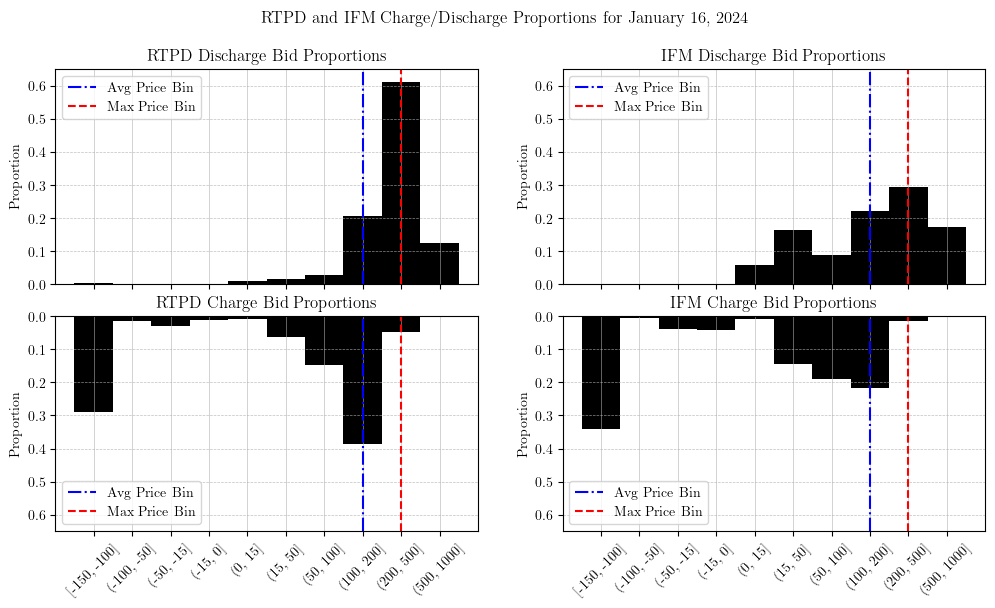

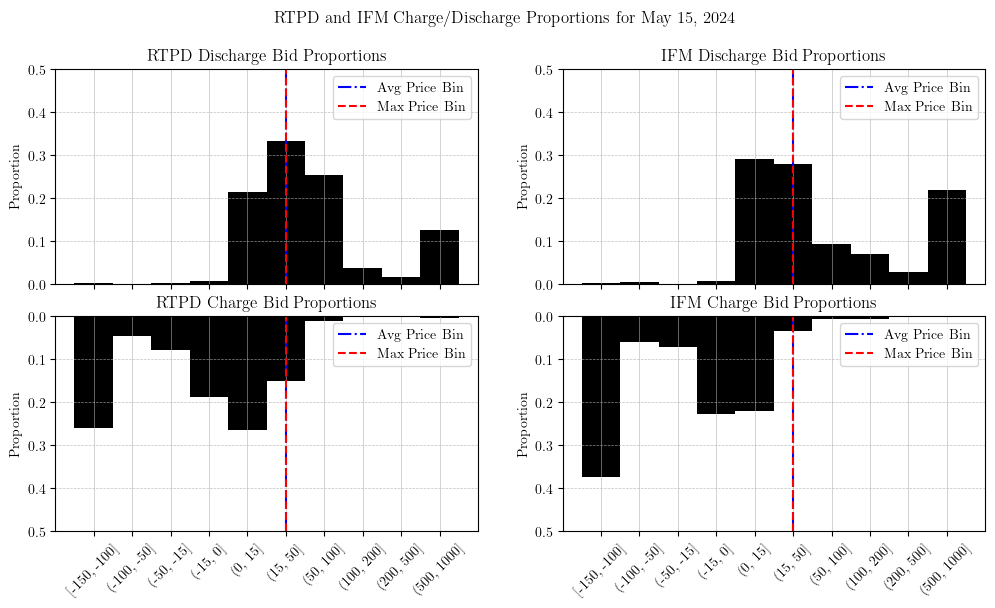

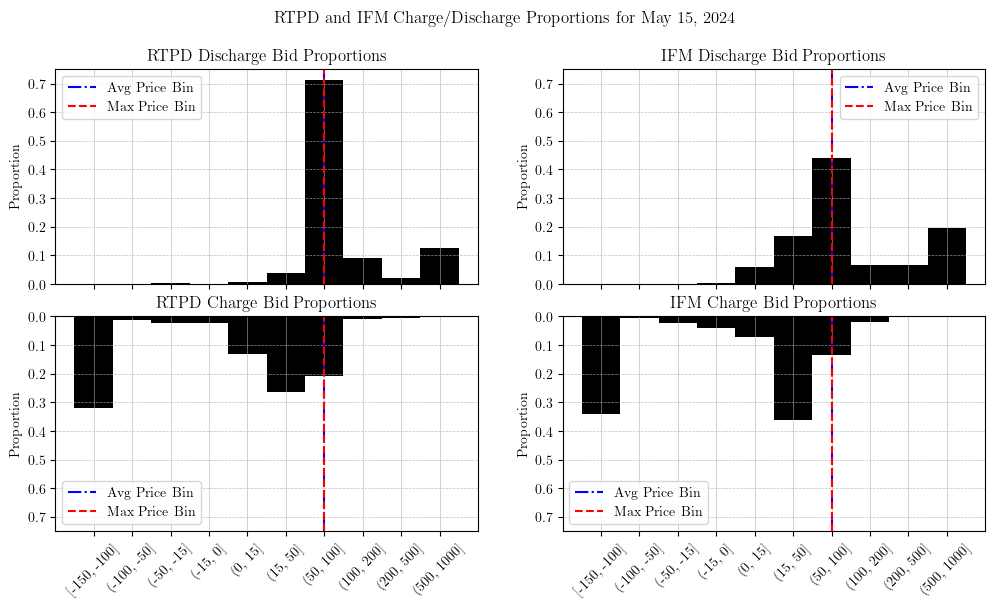

In [156]:
plot_bid_distribution(
    data=daily_df,
    start_date=pd.Timestamp("January 16, 2024"),
    end_date=pd.Timestamp("January 16, 2024"),
    date_descriptor="January 16, 2024",
    savefile="Jan16_2024_PriceSpikeBidDist",
)

plot_bid_distribution(
    data=daily_df,
    start_date=pd.Timestamp("May 15, 2024"),
    end_date=pd.Timestamp("May 15, 2024"),
    date_descriptor="May 15, 2024",
    savefile="May15_2024_NonPriceSpikeBidDist",
)

plot_bid_distribution(
    data=daily_df,
    start_date=pd.Timestamp("January 22, 2024"),
    end_date=pd.Timestamp("January 22, 2024"),
    date_descriptor="May 15, 2024",
    savefile="May15_2024_NonPriceSpikeBidDist",
)

## Stacked Hourly Bid Distribution

In [146]:
def plot_stacked_hourly_bid_distribution(df, start_date, end_date):
    # Filter data between start_date and end_date
    df_filtered_hourly = df[(df.index >= start_date) & (df.index <= end_date)]

    # Resample data to hourly frequency
    df_hourly = df_filtered_hourly.resample("h").mean()

    # Extract hour of the day
    df_hourly["hour"] = df_hourly.index.hour

    # Define bid segment columns
    suffixes = ["ss"] + [str(i) for i in range(1, 12)]
    rtpd_pos_columns = [f"bid_rtpd_pos_{suffix}" for suffix in suffixes]
    rtpd_neg_columns = [f"bid_rtpd_neg_{suffix}" for suffix in suffixes]
    ifm_pos_columns = [f"bid_ifm_pos_{suffix}" for suffix in suffixes]
    ifm_neg_columns = [f"bid_ifm_neg_{suffix}" for suffix in suffixes]

    # Plot stacked distributions
    fig, axs = plt.subplots(2, 2, figsize=(16, 12), sharex=True)

    cmap_selection = "nipy_spectral"
    for ax in axs.flat:
        ax.set_ylim(0, 1)
    # RTPD Discharge bids
    df_hourly[rtpd_pos_columns].div(
        df_hourly[rtpd_pos_columns].sum(axis=1), axis=0
    ).plot(kind="bar", stacked=True, ax=axs[0, 0], width=1.0, colormap=cmap_selection)
    axs[0, 0].set_title("RTPD Discharge Bids")
    axs[0, 0].set_ylabel("Proportion")
    axs[0, 0].grid(True, which="both", axis="y", linestyle="--", linewidth=0.5)

    # RTPD Charge bids
    df_hourly[rtpd_neg_columns].div(
        df_hourly[rtpd_neg_columns].sum(axis=1), axis=0
    ).plot(kind="bar", stacked=True, ax=axs[1, 0], width=1.0, colormap=cmap_selection)
    axs[1, 0].set_title("RTPD Charge Bids")
    axs[1, 0].set_ylabel("Proportion")
    axs[1, 0].set_xlabel("Hour of the Day")
    axs[1, 0].grid(True, which="both", axis="y", linestyle="--", linewidth=0.5)

    # IFM Discharge bids
    df_hourly[ifm_pos_columns].div(df_hourly[ifm_pos_columns].sum(axis=1), axis=0).plot(
        kind="bar", stacked=True, ax=axs[0, 1], width=1.0, colormap=cmap_selection
    )
    axs[0, 1].set_title("IFM Discharge Bids")
    axs[0, 1].grid(True, which="both", axis="y", linestyle="--", linewidth=0.5)

    # IFM Charge bids
    df_hourly[ifm_neg_columns].div(df_hourly[ifm_neg_columns].sum(axis=1), axis=0).plot(
        kind="bar", stacked=True, ax=axs[1, 1], width=1.0, colormap=cmap_selection
    )
    axs[1, 1].set_title("IFM Charge Bids")
    axs[1, 1].set_xlabel("Hour of the Day")
    axs[1, 1].grid(True, which="both", axis="y", linestyle="--", linewidth=0.5)

    # Create a single legend
    handles, labels = axs[0, 0].get_legend_handles_labels()
    for ax in axs.flat:
        ax.legend().remove()
    legend_labels = [f"Segment: {bid_segments[suffix]}" for suffix in suffixes]
    fig.legend(handles, legend_labels, loc="center left", bbox_to_anchor=(1.0, 0.5))

    plt.tight_layout()
    plt.show()

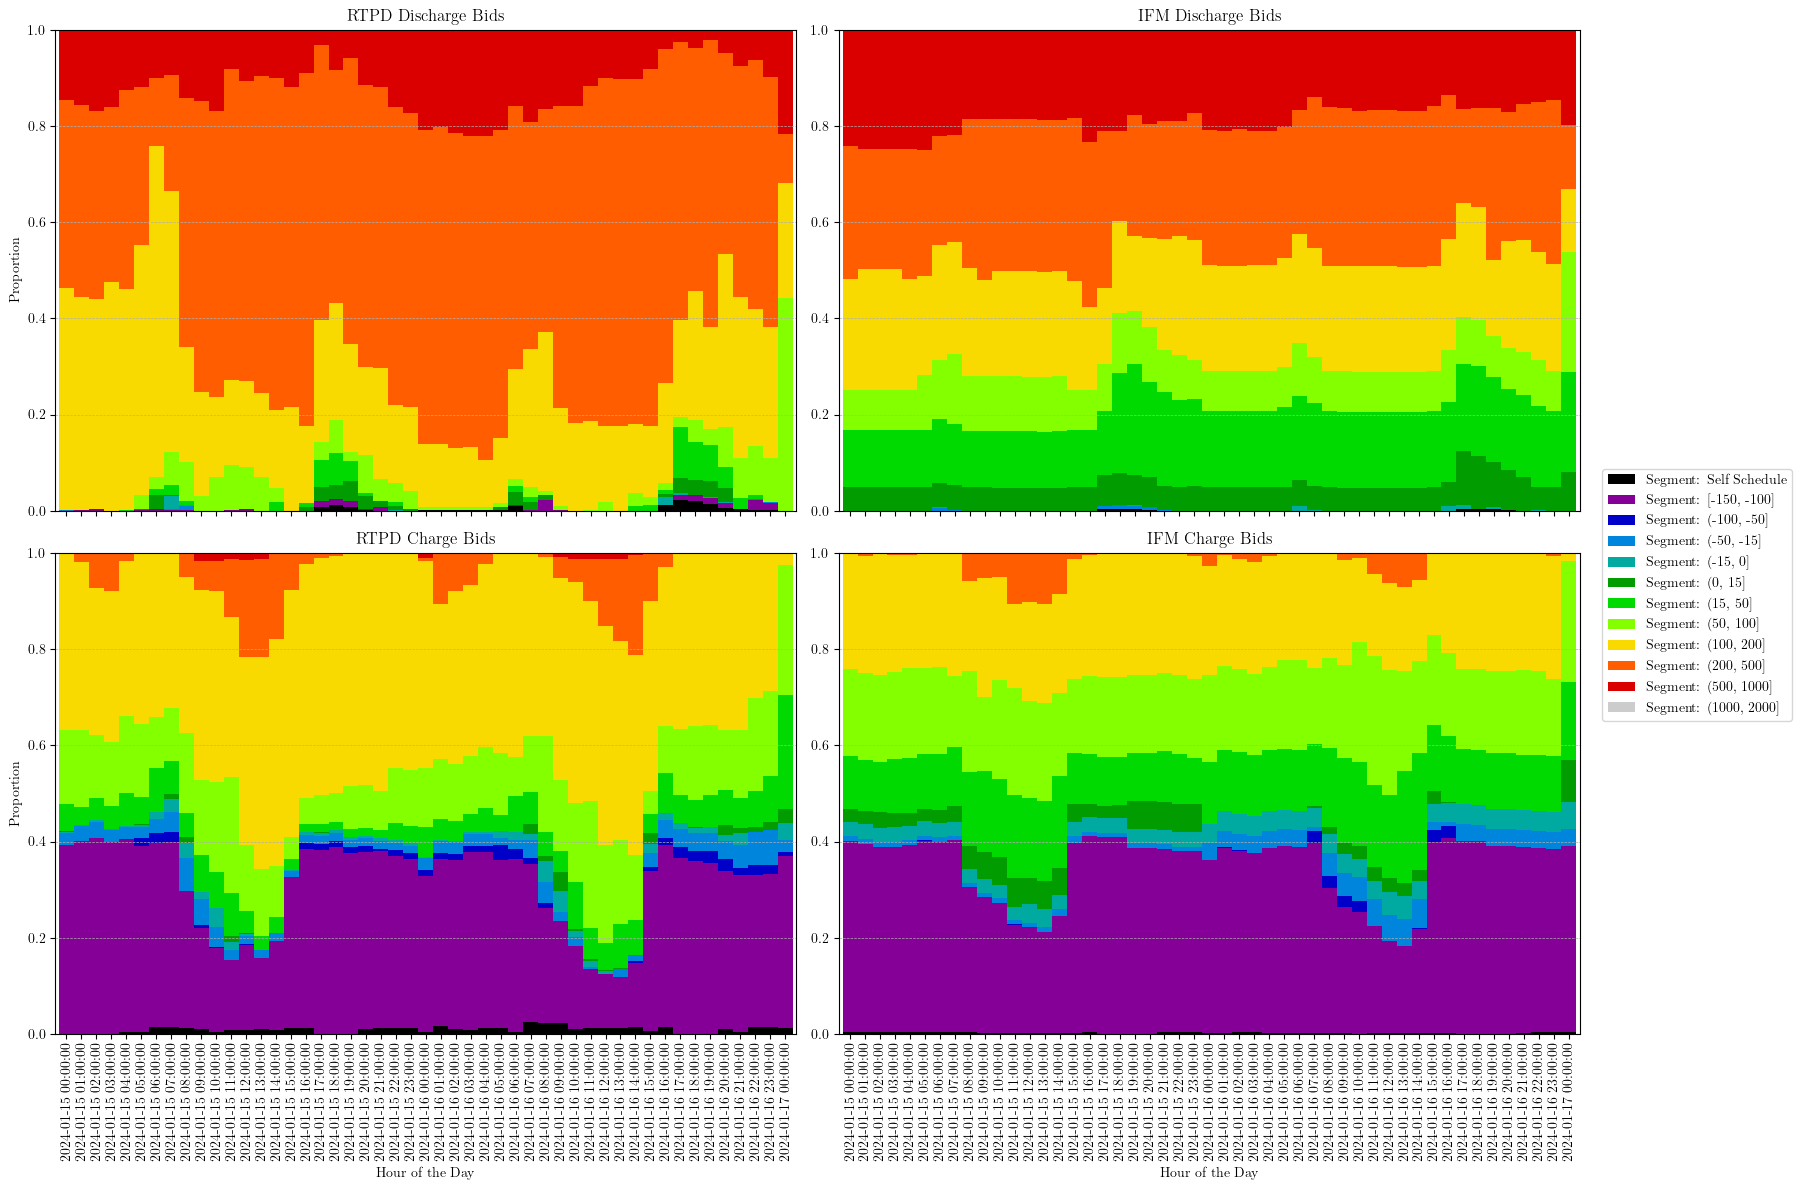

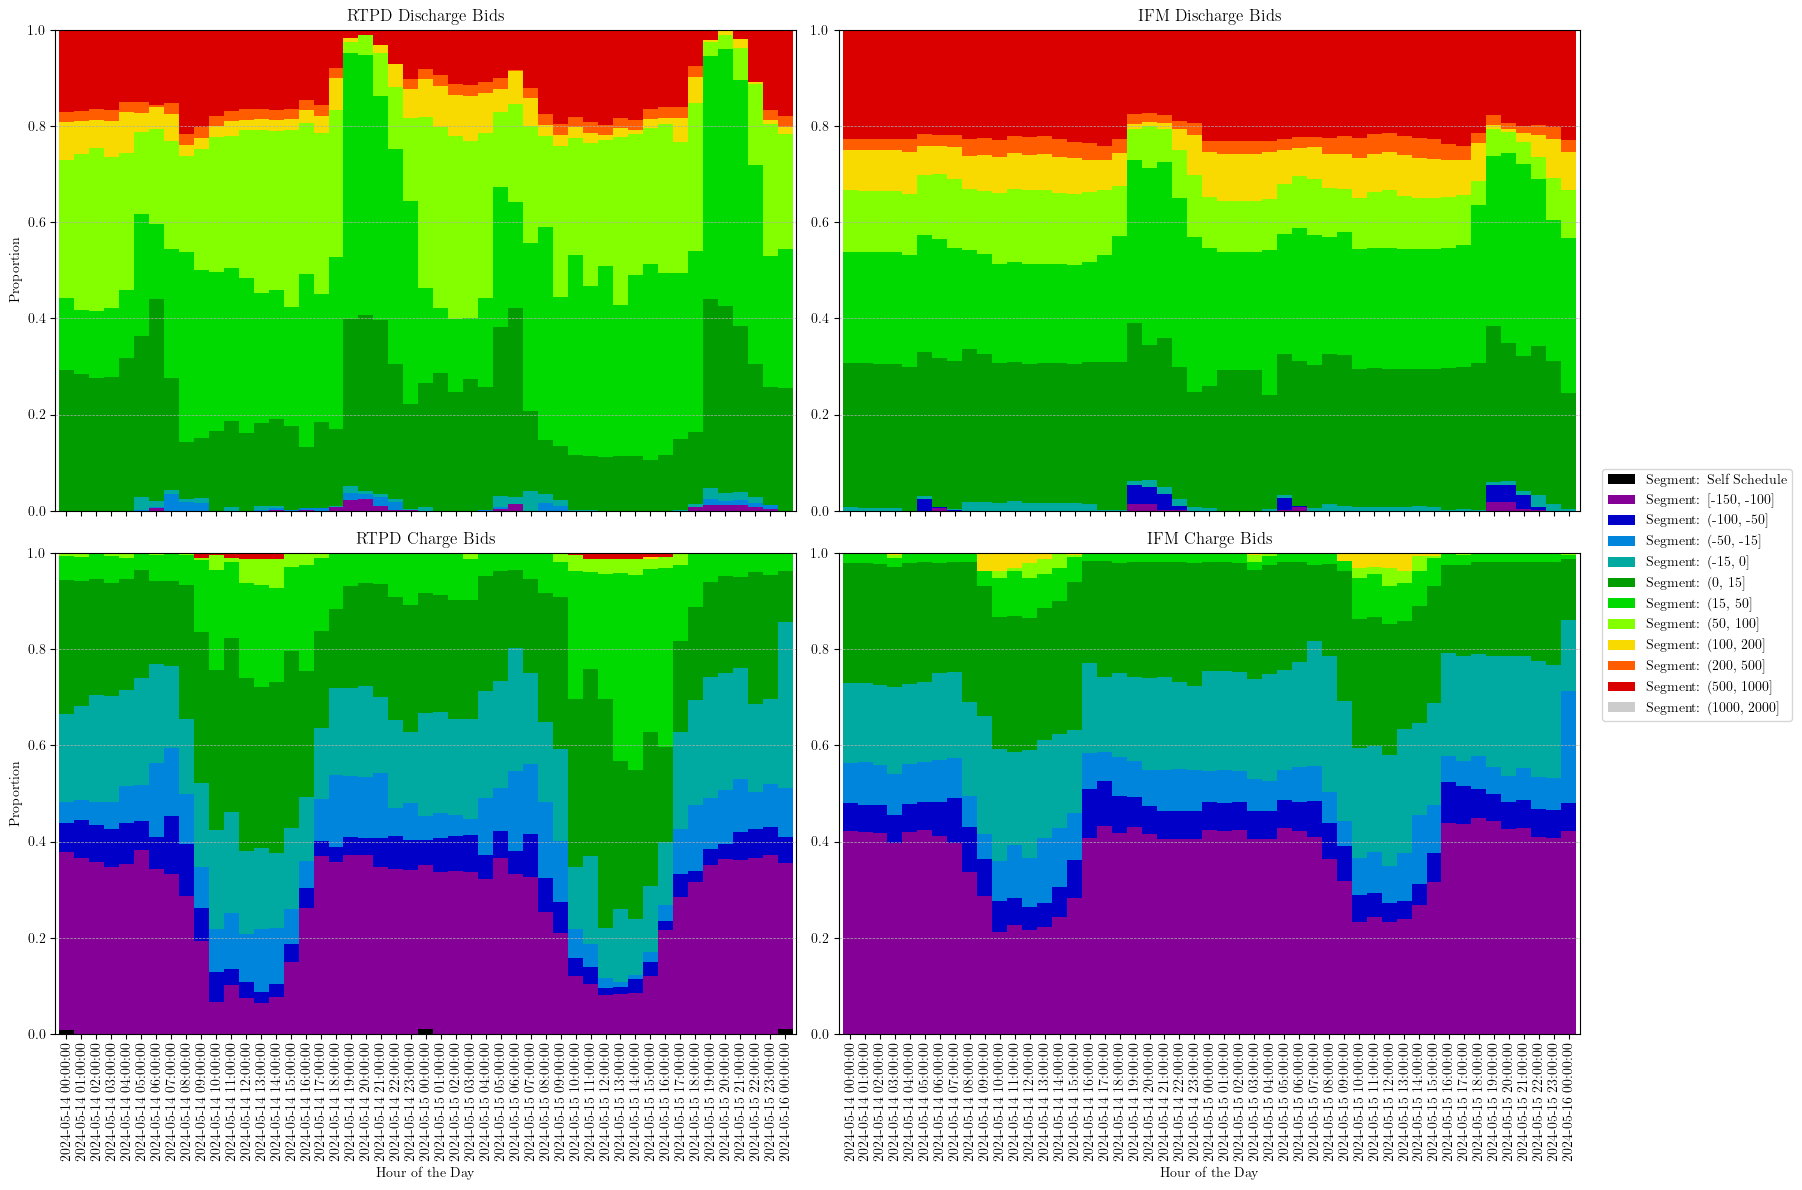

In [150]:
plot_stacked_hourly_bid_distribution(
    df=hourly_df,
    start_date=pd.Timestamp("January 15, 2024"),
    end_date=pd.Timestamp("January 17, 2024"),
)

plot_stacked_hourly_bid_distribution(
    df=hourly_df,
    start_date=pd.Timestamp("May 14, 2024"),
    end_date=pd.Timestamp("May 16, 2024"),
)

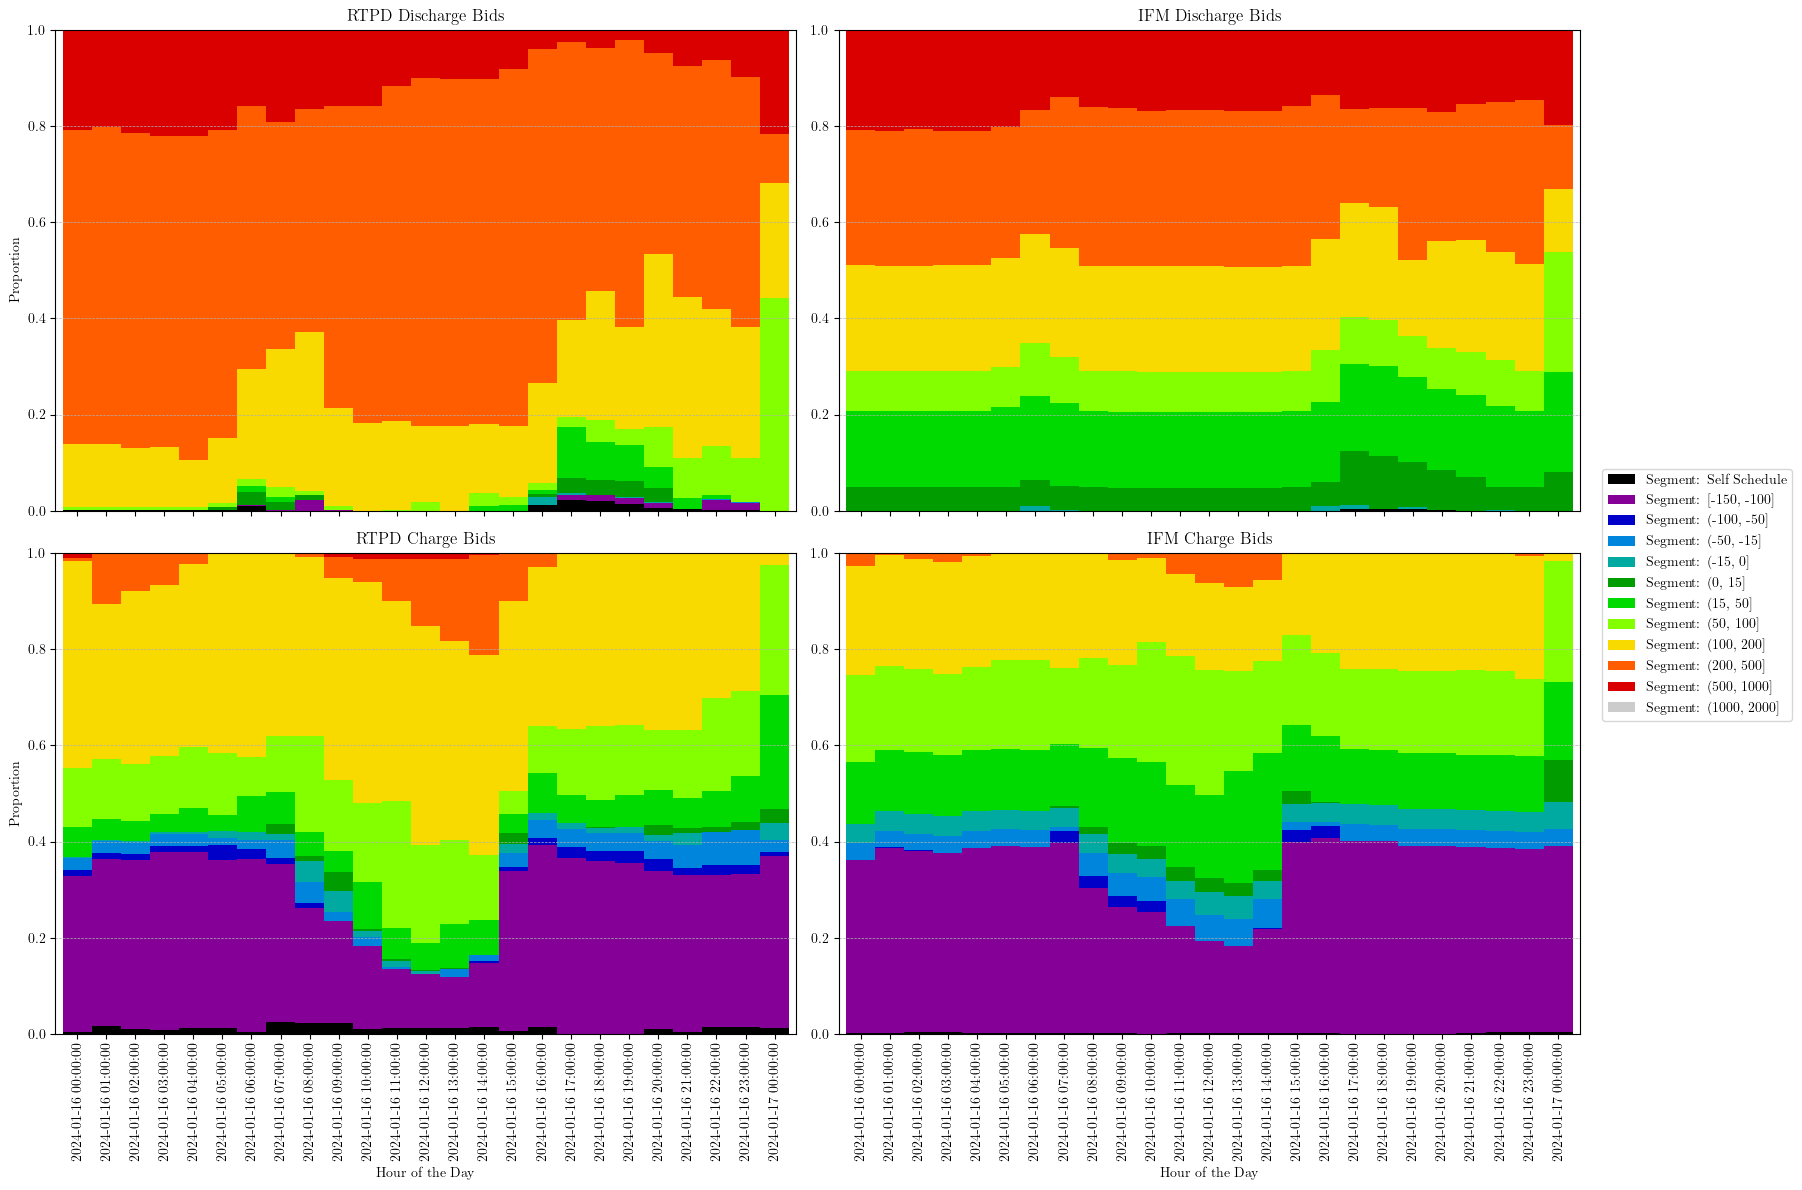

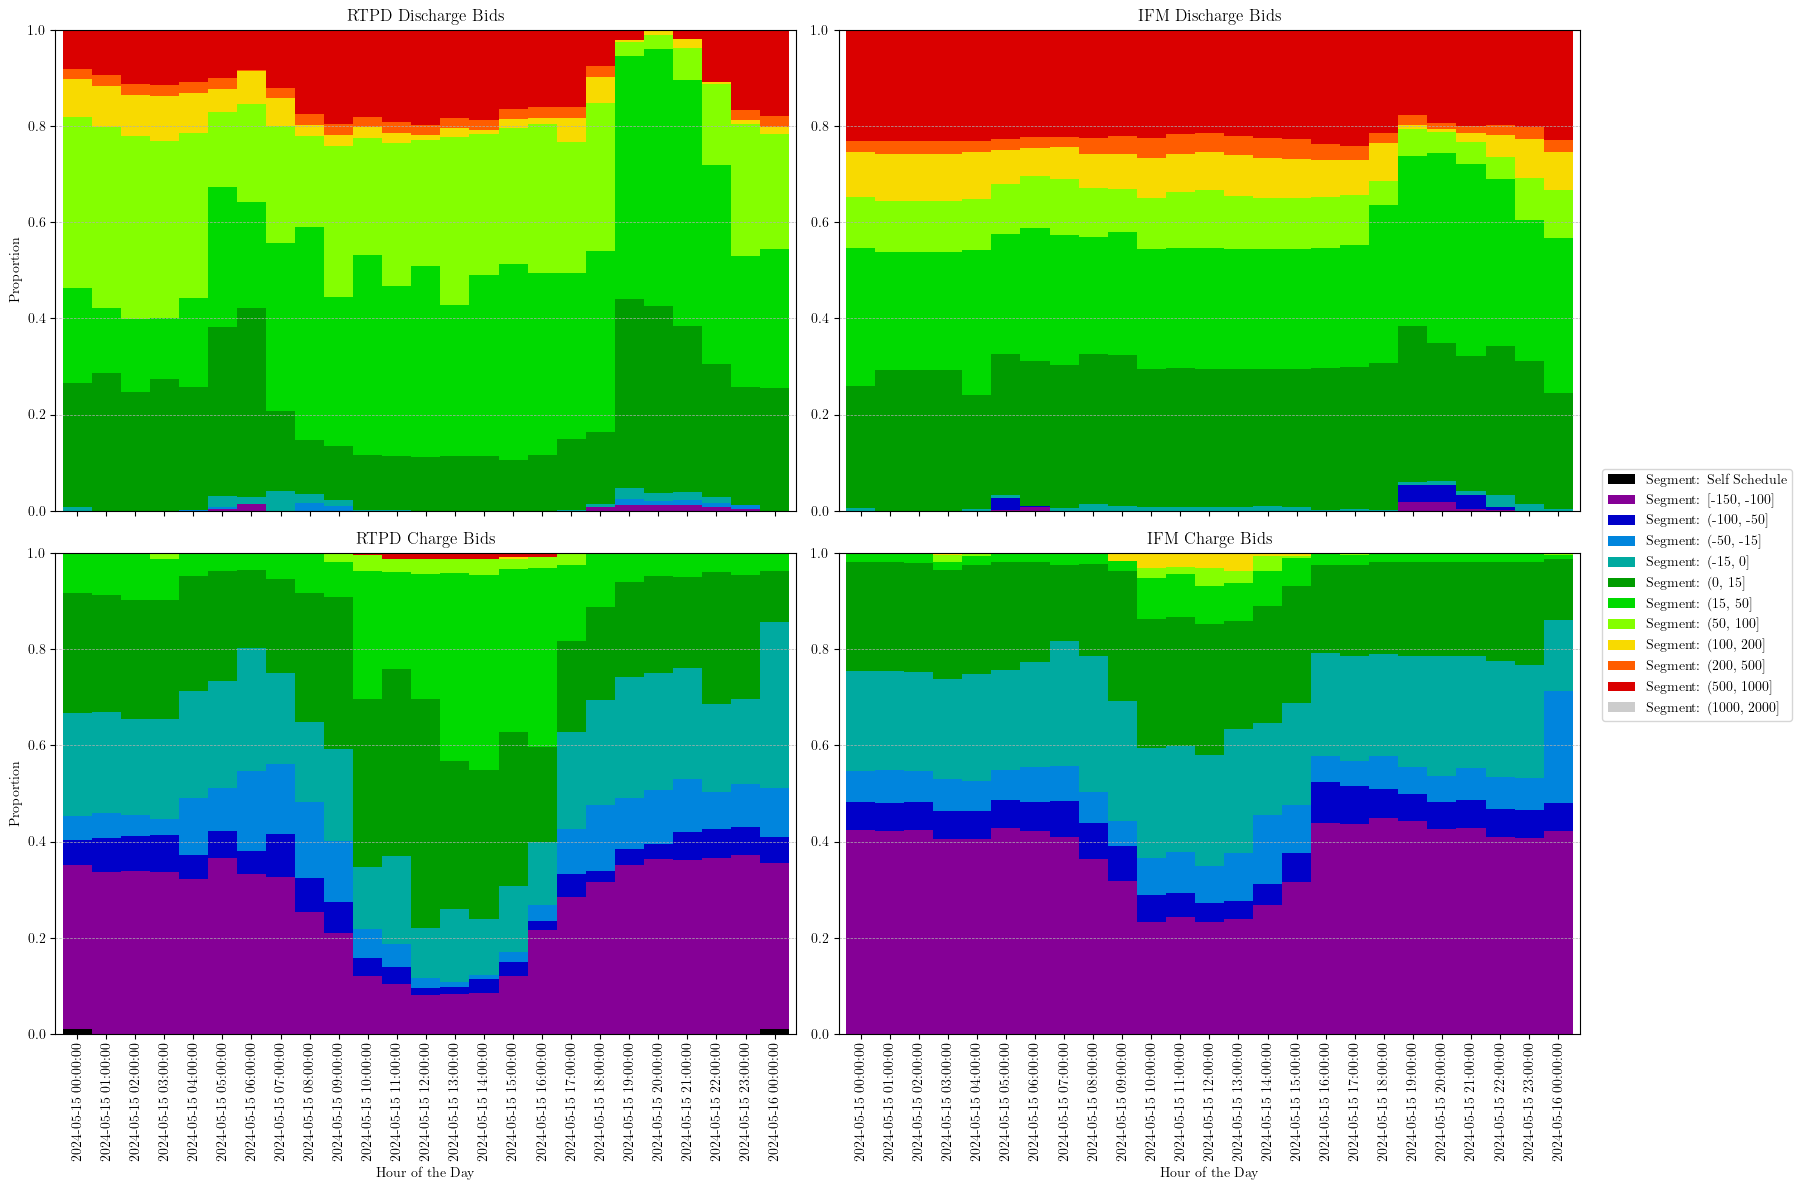

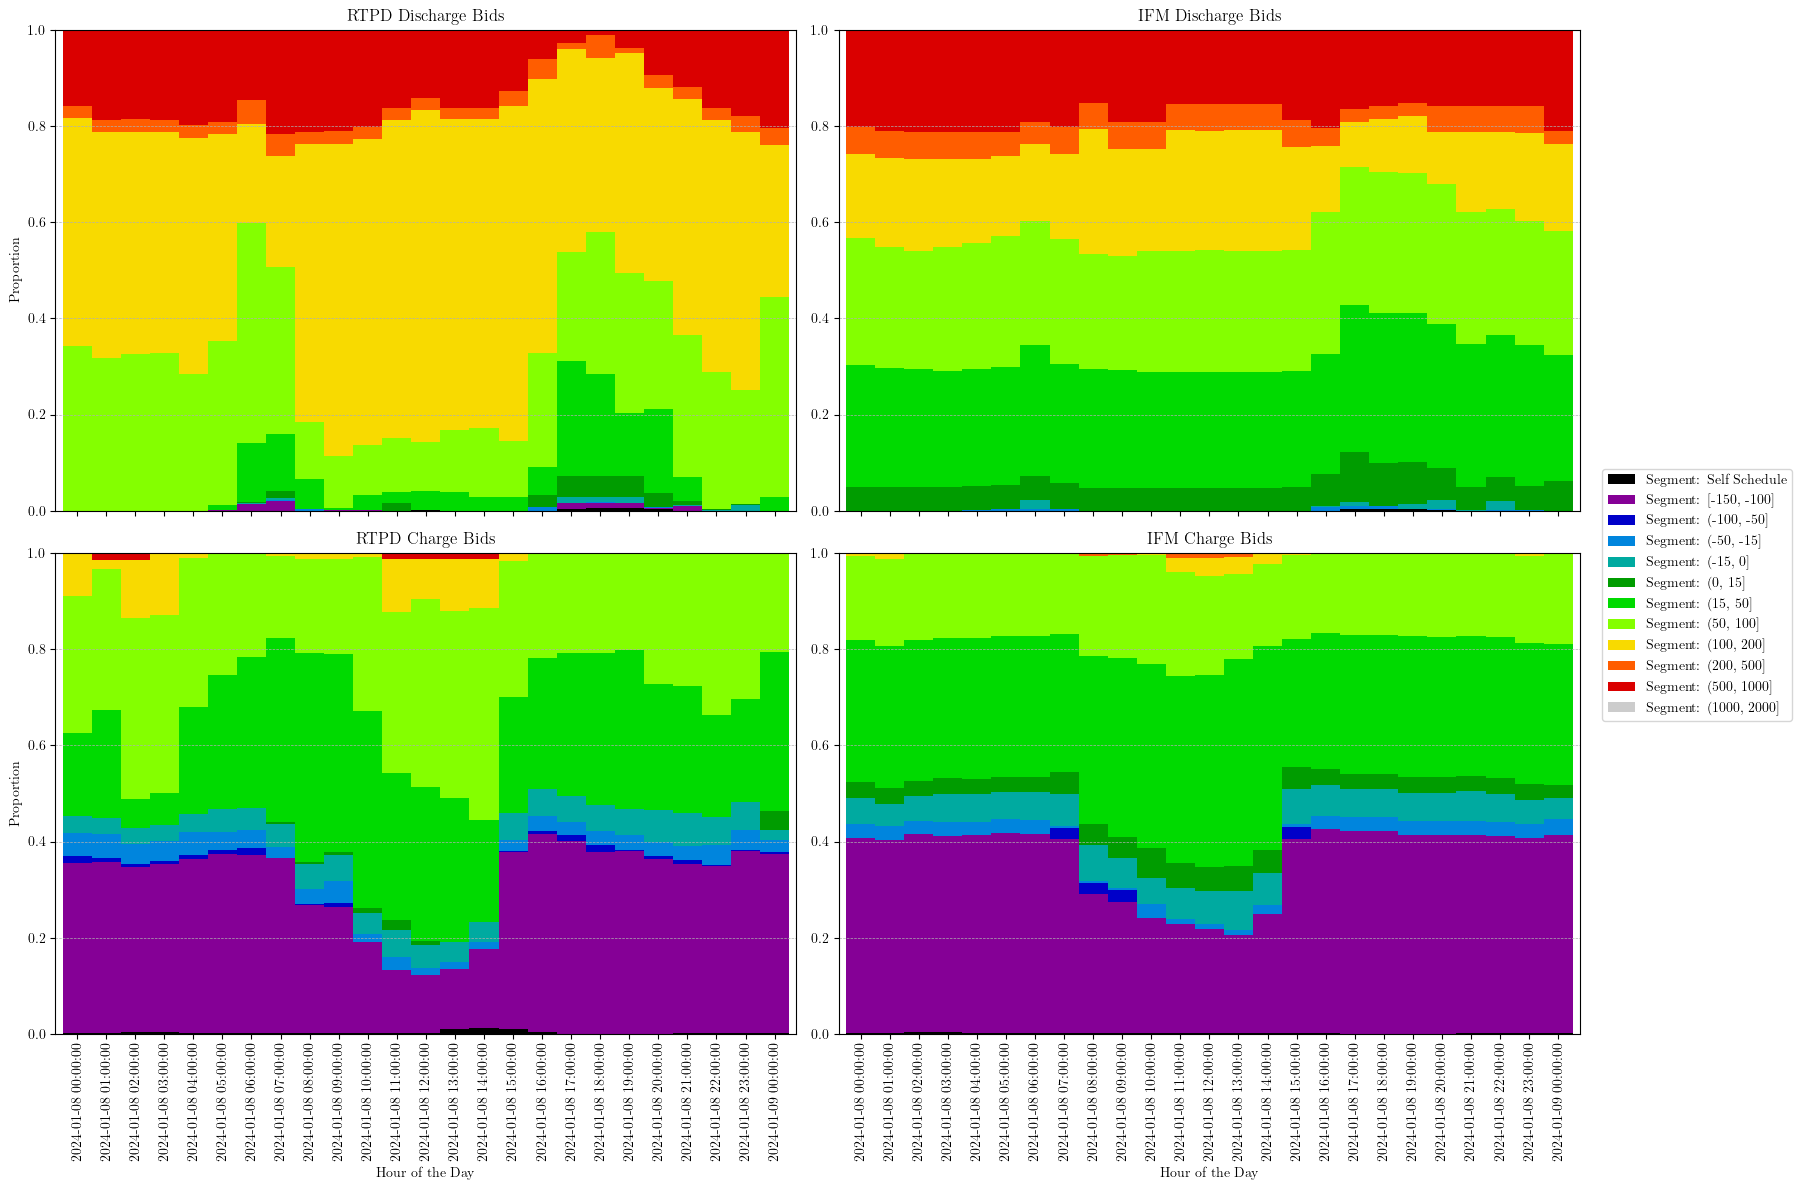

In [157]:
plot_stacked_hourly_bid_distribution(
    df=hourly_df,
    start_date=pd.Timestamp("January 16, 2024"),
    end_date=pd.Timestamp("January 17, 2024"),
)

plot_stacked_hourly_bid_distribution(
    df=hourly_df,
    start_date=pd.Timestamp("May 15, 2024"),
    end_date=pd.Timestamp("May 16, 2024"),
)

plot_stacked_hourly_bid_distribution(
    df=hourly_df,
    start_date=pd.Timestamp("January 8, 2024"),
    end_date=pd.Timestamp("January 9, 2024"),
)

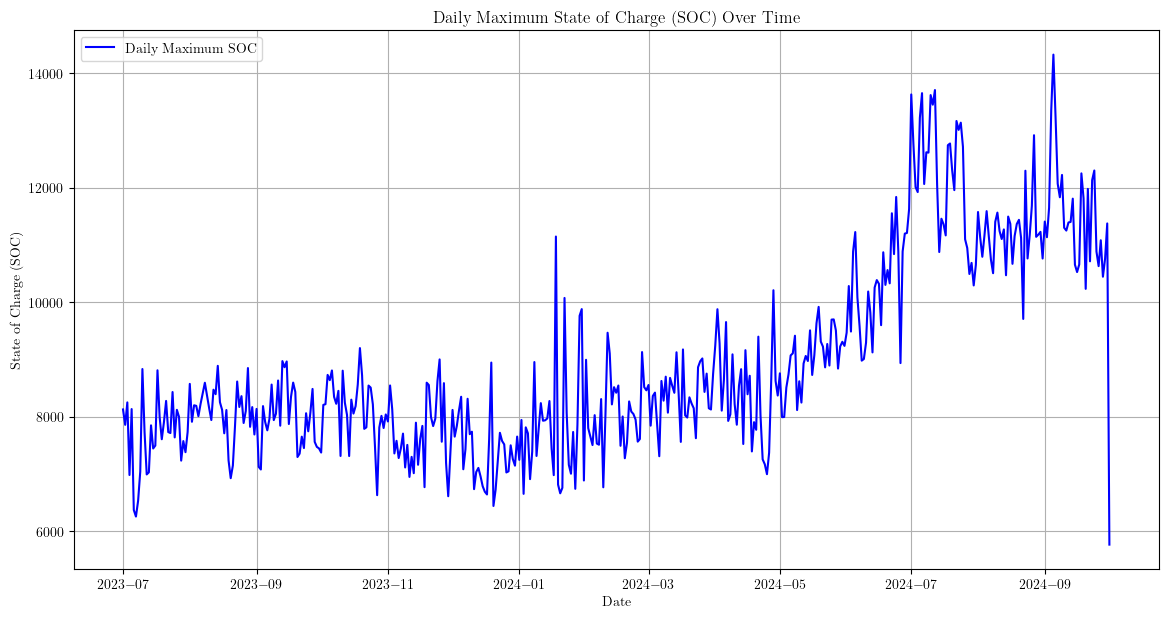

In [155]:
# Assuming 'tot_charge_rtd' represents the State of Charge (SOC) in the dataset
daily_max_soc = daily_df["tot_charge_ifm"].resample("D").max()

plt.figure(figsize=(14, 7))
plt.plot(daily_max_soc.index, daily_max_soc, label="Daily Maximum SOC", color="blue")
plt.title("Daily Maximum State of Charge (SOC) Over Time")
plt.xlabel("Date")
plt.ylabel("State of Charge (SOC)")
plt.legend()
plt.grid(True)
plt.show()